## Imports

In [1]:
import pandas as pd
import numpy  as np
import seaborn as sns

import pickle
import requests
import json

import warnings
warnings.filterwarnings( 'ignore' )

import matplotlib.pyplot as plt
from IPython.core.display    import HTML
from scikitplot              import metrics as mt
from sklearn.preprocessing   import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble        import RandomForestClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.ensemble        import ExtraTreesClassifier
from lightgbm                import LGBMClassifier
from sklearn.metrics         import roc_auc_score

import xgboost             as xgb
import scikitplot.metrics  as mtr


from sklearn.metrics      import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

## Import Data

In [2]:
df_raw = pd.read_csv('horses_ds.csv')
df_raw = df_raw.drop(['Unnamed: 0'], axis=1)

## Functions

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display (HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    sns.set()

jupyter_settings()

def without_hue(plot, feature):
    total = len(feature)
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        plot.annotate(percentage, (x, y), size = 20)
        plot.tick_params(axis='x', labelsize=15)
    plt.show()
    
def with_hue(plot, feature, number_of_categories, hue_categories):
    a = [p.get_height() for p in plot.patches]
    patch = [p for p in plot.patches]
    for i in range(number_of_categories):
        total = a[i] + a[i+number_of_categories]
        for j in range(hue_categories):
            percentage = '{:.1f}%'.format(100 * a[(j*number_of_categories + i)]/total)
            x = patch[(j*number_of_categories + i)].get_x() + patch[(j*number_of_categories + i)].get_width() / 2
            y = patch[(j*number_of_categories + i)].get_y() + patch[(j*number_of_categories + i)].get_height() 
            plot.annotate(percentage, (x, y), size = 20)
            plot.tick_params(axis='x', labelsize=15)
    plt.show()
    

Populating the interactive namespace from numpy and matplotlib


In [4]:
def roc_cross_validation(pos, k, verbose=False):

    #aux0 = ['id', 'response']
    #df_aux = df5[aux0]
    df_aux = df5
    df_aux['id'] = df5.index+1
    aux = len(df_aux) / k
    roc_values_cv = []

    for i in (range(1, k+1)):
    
        ka = aux*i
        
        df_tr = df_aux[(df_aux['id'] < (ka - aux)) | (df_aux['id'] > ka)]
        df_te = df_aux[(df_aux['id'] > (ka - aux)) & (df_aux['id'] < ka)]

        df_tr = df_tr.drop(df_tr.columns[[0]], axis=1)
        df_te = df_te.drop(df_te.columns[[0]], axis=1)

        X_tr = df_tr.drop(['outcome'], axis=1).copy()
        y_tr = df_tr[['outcome']].copy()

    
        X_te = df_te.drop(['outcome'], axis=1).copy()
        y_te = df_te[['outcome']].copy()
    
        models[pos].fit(X_tr, y_tr.values.ravel())
        yhat_aux = models[pos].predict_proba(X_te)
        roc_aux =roc_auc_score(y_te, yhat_aux[:, 1])
        roc_values_cv.append(roc_aux)
    
    return roc_values_cv

In [5]:
def metrics_score(model_name, y_test, yhat):
    acc = accuracy_score(y_test, yhat)
    pre = precision_score(y_test, yhat)
    rec = recall_score(y_test, yhat)
    ras = roc_auc_score(y_test, yhat_lgbm[:,1])
    f1s = f1_score(y_test, yhat)
    
    return pd.DataFrame([[model_name, acc, pre, rec, ras, f1s]],
                        columns = ['Model', 'accuracy', 'precision', 'recall', 'roc_auc_score', 'f1_score'])

## Feature Description

Attribute Information:

1: surgery? 
1 = Yes, it had surgery 
2 = It was treated without surgery 

2: Age 
1 = Adult horse 
2 = Young (< 6 months) 

3: Hospital Number 
- numeric id 
- the case number assigned to the horse (may not be unique if the horse is treated > 1 time) 

4: rectal temperature 
- linear 
- in degrees celsius. 
- An elevated temp may occur due to infection. 
- temperature may be reduced when the animal is in late shock 
- normal temp is 37.8 
- this parameter will usually change as the problem progresses, eg. may start out normal, then become elevated because of the lesion, passing back through the normal range as the horse goes into shock 
5: pulse 
- linear 
- the heart rate in beats per minute 
- is a reflection of the heart condition: 30 -40 is normal for adults 
- rare to have a lower than normal rate although athletic horses may have a rate of 20-25 
- animals with painful lesions or suffering from circulatory shock may have an elevated heart rate 

6: respiratory rate 
- linear 
- normal rate is 8 to 10 
- usefulness is doubtful due to the great fluctuations 

7: temperature of extremities 
- a subjective indication of peripheral circulation 
- possible values: 
1 = Normal 
2 = Warm 
3 = Cool 
4 = Cold 
- cool to cold extremities indicate possible shock 
- hot extremities should correlate with an elevated rectal temp. 

8: peripheral pulse 
- subjective 
- possible values are: 
1 = normal 
2 = increased 
3 = reduced 
4 = absent 
- normal or increased p.p. are indicative of adequate circulation while reduced or absent indicate poor perfusion 

9: mucous membranes 
- a subjective measurement of colour 
- possible values are: 
1 = normal pink 
2 = bright pink 
3 = pale pink 
4 = pale cyanotic 
5 = bright red / injected 
6 = dark cyanotic 
- 1 and 2 probably indicate a normal or slightly increased circulation 
- 3 may occur in early shock 
- 4 and 6 are indicative of serious circulatory compromise 
- 5 is more indicative of a septicemia 

10: capillary refill time 
- a clinical judgement. The longer the refill, the poorer the circulation 
- possible values 
1 = < 3 seconds 
2 = >= 3 seconds 

11: pain - a subjective judgement of the horse's pain level 
- possible values: 
1 = alert, no pain 
2 = depressed 
3 = intermittent mild pain 
4 = intermittent severe pain 
5 = continuous severe pain 
- should NOT be treated as a ordered or discrete variable! 
- In general, the more painful, the more likely it is to require surgery 
- prior treatment of pain may mask the pain level to some extent 

12: peristalsis 
- an indication of the activity in the horse's gut. As the gut becomes more distended or the horse becomes more toxic, the activity decreases 
- possible values: 
1 = hypermotile 
2 = normal 
3 = hypomotile 
4 = absent 

13: abdominal distension 
- An IMPORTANT parameter. 
- possible values 
1 = none 
2 = slight 
3 = moderate 
4 = severe 
- an animal with abdominal distension is likely to be painful and have reduced gut motility. 
- a horse with severe abdominal distension is likely to require surgery just to relieve the pressure 

14: nasogastric tube 
- this refers to any gas coming out of the tube 
- possible values: 
1 = none 
2 = slight 
3 = significant 
- a large gas cap in the stomach is likely to give the horse discomfort 

15: nasogastric reflux 
- possible values 
1 = none 
2 = > 1 liter 
3 = < 1 liter 
- the greater amount of reflux, the more likelihood that there is some serious obstruction to the fluid passage from the rest of the intestine 

16: nasogastric reflux PH 
- linear 
- scale is from 0 to 14 with 7 being neutral 
- normal values are in the 3 to 4 range 

17: rectal examination - feces 
- possible values 
1 = normal 
2 = increased 
3 = decreased 
4 = absent 
- absent feces probably indicates an obstruction 

18: abdomen 
- possible values 
1 = normal 
2 = other 
3 = firm feces in the large intestine 
4 = distended small intestine 
5 = distended large intestine 
- 3 is probably an obstruction caused by a mechanical impaction and is normally treated medically 
- 4 and 5 indicate a surgical lesion 

19: packed cell volume 
- linear 
- the percentage of red cells by volume in the blood 
- normal range is 30 to 50. The level rises as the circulation becomes compromised or as the animal becomes dehydrated. 

20: total protein 
- linear 
- normal values lie in the 6-7.5 (gms/dL) range 
- the higher the value the greater the dehydration 

21: abdominocentesis appearance 
- a needle is put in the horse's abdomen and fluid is obtained from 
the abdominal cavity 
- possible values: 
1 = clear 
2 = cloudy 
3 = serosanguinous 
- normal fluid is clear while cloudy or serosanguinous indicates a compromised gut 

22: abdomcentesis total protein 
- linear 
- the higher the level of protein the more likely it is to have a compromised gut. Values are in gms/dL 

23: outcome 
- what eventually happened to the horse? 
- possible values: 
1 = lived 
2 = died 
3 = was euthanized 

24: surgical lesion? 
- retrospectively, was the problem (lesion) surgical? 
- all cases are either operated upon or autopsied so that this value and the lesion type are always known 
- possible values: 
1 = Yes 
2 = No 

25, 26, 27: type of lesion 
- first number is site of lesion 
1 = gastric 
2 = sm intestine 
3 = lg colon 
4 = lg colon and cecum 
5 = cecum 
6 = transverse colon 
7 = retum/descending colon 
8 = uterus 
9 = bladder 
11 = all intestinal sites 
00 = none 
- second number is type 
1 = simple 
2 = strangulation 
3 = inflammation 
4 = other 
- third number is subtype 
1 = mechanical 
2 = paralytic 
0 = n/a 
- fourth number is specific code 
1 = obturation 
2 = intrinsic 
3 = extrinsic 
4 = adynamic 
5 = volvulus/torsion 
6 = intussuption 
7 = thromboembolic 
8 = hernia 
9 = lipoma/slenic incarceration 
10 = displacement 
0 = n/a 

28: cp_data 
- is pathology data present for this case? 
1 = Yes 
2 = No 
- this variable is of no significance since pathology data is not included or collected for these cases

# 1.0 Data Description

In [6]:
df1 = df_raw.copy()

In [7]:
df1.head()

,surgery,age,hospital_number,rectal_temp,pulse,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,abdomen,packed_cell_volume,total_protein,abdomo_appearance,outcome,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,no,young,5294539,38.2,52.0,warm,normal,normal_pink,less_3_sec,alert,hypermotile,none,1,1,0,normal,33.0,3.3,clear,died,no,0,0,0,no
1,no,adult,530670,37.3,50.0,cool,normal,normal_pink,less_3_sec,alert,hypermotile,none,2,1,0,normal,42.0,6.0,cloudy,died,no,0,0,0,no
2,no,adult,529960,38.6,56.0,cool,increased,pale_pink,less_3_sec,alert,hypermotile,none,1,1,0,normal,42.0,7.3,clear,lived,no,0,0,0,no
3,no,adult,530360,38.3,50.0,cool,normal,normal_pink,less_3_sec,alert,hypermotile,none,2,1,0,normal,42.0,7.5,clear,died,no,0,0,0,yes
4,no,adult,530670,37.3,40.0,warm,normal,normal_pink,less_3_sec,alert,hypermotile,none,0,0,0,normal,39.0,6.0,cloudy,died,no,0,0,0,no


## 1.1 Data Dimension

In [8]:
print('number of rows {}'.format(df1.shape[0]))
print('number of cols {}'.format(df1.shape[1]))

number of rows 20000
number of cols 25


## 1.2 Data Columns

In [9]:
df1.columns

Index(['surgery', 'age', 'hospital_number', 'rectal_temp', 'pulse',
       'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane',
       'capillary_refill_time', 'pain', 'peristalsis', 'abdominal_distention',
       'nasogastric_tube', 'nasogastric_reflux', 'nasogastric_reflux_ph',
       'abdomen', 'packed_cell_volume', 'total_protein', 'abdomo_appearance',
       'outcome', 'surgical_lesion', 'lesion_1', 'lesion_2', 'lesion_3',
       'cp_data'],
      dtype='object')

## 1.3 Data Types

In [10]:
df1.dtypes

surgery                   object
age                       object
hospital_number            int64
rectal_temp              float64
pulse                    float64
temp_of_extremities       object
peripheral_pulse          object
mucous_membrane           object
capillary_refill_time     object
pain                      object
peristalsis               object
abdominal_distention      object
nasogastric_tube           int64
nasogastric_reflux         int64
nasogastric_reflux_ph      int64
abdomen                   object
packed_cell_volume       float64
total_protein            float64
abdomo_appearance         object
outcome                   object
surgical_lesion           object
lesion_1                   int64
lesion_2                   int64
lesion_3                   int64
cp_data                   object
dtype: object

## 1.4 Check Na

In [11]:
df1.isna().sum()

surgery                  0
age                      0
hospital_number          0
rectal_temp              0
pulse                    0
temp_of_extremities      0
peripheral_pulse         0
mucous_membrane          0
capillary_refill_time    0
pain                     0
peristalsis              0
abdominal_distention     0
nasogastric_tube         0
nasogastric_reflux       0
nasogastric_reflux_ph    0
abdomen                  0
packed_cell_volume       0
total_protein            0
abdomo_appearance        0
outcome                  0
surgical_lesion          0
lesion_1                 0
lesion_2                 0
lesion_3                 0
cp_data                  0
dtype: int64

## 1.5 Descriptive Statistics

### 1.5.1 Numeric Attributes

In [12]:
df1_num = df1[['rectal_temp', 'pulse', 'packed_cell_volume', 'total_protein']]

ct1 = pd.DataFrame(df1_num.apply(np.mean)).T
ct2 = pd.DataFrame(df1_num.apply(np.median)).T

d1 = pd.DataFrame(df1_num.apply(np.std)).T
d2 = pd.DataFrame(df1_num.apply(min)).T
d3 = pd.DataFrame(df1_num.apply(max)).T
d4 = pd.DataFrame(df1_num.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(df1_num.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(df1_num.apply(lambda x: x.kurtosis())).T

ds = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
ds.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ds

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,rectal_temp,35.4,40.8,5.4,38.129740,38.2,0.705388,-0.163501,1.494244
1,pulse,36.0,184.0,148.0,72.188380,64.0,28.233487,1.144389,1.364001
2,packed_cell_volume,23.0,75.0,52.0,45.381375,44.0,9.789256,0.784195,0.262240
3,total_protein,3.3,85.0,81.7,21.878675,7.4,26.024617,1.216145,-0.386476


### 1.5.2 Categorical Attributes

In [13]:
df1['surgery'].value_counts()

yes    10856
no      9144
Name: surgery, dtype: int64

In [14]:
df1['age'].value_counts()

adult    18421
young     1579
Name: age, dtype: int64

In [15]:
df1['temp_of_extremities'].value_counts()

normal    7711
cool      7635
cold      2771
warm      1883
Name: temp_of_extremities, dtype: int64

In [16]:
df1['peripheral_pulse'].value_counts()

normal       10642
reduced       8391
absent         553
increased      414
Name: peripheral_pulse, dtype: int64

In [17]:
df1['mucous_membrane'].value_counts()

normal_pink      6884
pale_pink        4290
pale_cyanotic    3756
bright_pink      2192
bright_red       1573
dark_cyanotic    1305
Name: mucous_membrane, dtype: int64

In [18]:
df1['capillary_refill_time'].value_counts()

less_3_sec    14447
more_3_sec     5388
3               165
Name: capillary_refill_time, dtype: int64

In [19]:
df1['pain'].value_counts()

mild_pain       6400
depressed       4890
alert           3274
extreme_pain    2934
severe_pain     2502
Name: pain, dtype: int64

In [20]:
df1['peristalsis'].value_counts()

hypomotile     10058
absent          5530
hypermotile     3163
normal          1249
Name: peristalsis, dtype: int64

In [21]:
df1['abdominal_distention'].value_counts()

none        6823
moderate    5890
slight      5204
severe      2083
Name: abdominal_distention, dtype: int64

In [22]:
df1['nasogastric_tube'].value_counts()

2    8145
0    5196
1    4919
3    1740
Name: nasogastric_tube, dtype: int64

In [23]:
df1['nasogastric_reflux'].value_counts()

1    9210
0    5295
3    3053
2    2442
Name: nasogastric_reflux, dtype: int64

In [24]:
df1['nasogastric_reflux_ph'].value_counts()

0    14505
3     4563
1      752
2      180
Name: nasogastric_reflux_ph, dtype: int64

In [25]:
df1['abdomen'].value_counts()

distend_large    6872
distend_small    5098
normal           3377
other            2602
firm             2051
Name: abdomen, dtype: int64

In [26]:
df1['abdomo_appearance'].value_counts()

serosanguious    8061
cloudy           6110
clear            5829
Name: abdomo_appearance, dtype: int64

In [27]:
df1['surgical_lesion'].value_counts()

yes    12172
no      7828
Name: surgical_lesion, dtype: int64

In [28]:
df1['lesion_1'].value_counts() 

0        3977
3111     2108
3205     1742
2208     1254
2205      925
2209      922
7111      799
2124      691
2111      437
400       406
2112      402
4205      391
31110     354
1400      336
2207      317
5124      298
2113      271
5206      271
2206      258
3209      254
3025      230
300       221
4300      204
6111      198
5111      190
7400      185
7209      179
8400      156
5000      141
5400      136
3113      131
1124      119
6209      113
6112      110
4206      108
3124      107
2300      107
4124      100
11400      96
4207       81
3112       80
12208      74
8300       73
3300       68
2305       68
9400       65
3207       65
2322       57
3133       27
3115       23
4209        9
1111        6
6400        4
1112        4
2133        3
1209        3
9111        2
12209       2
3028        2
7300        2
6005        2
2200        2
6300        2
1208        2
5300        2
111         1
4111        1
205         1
11000       1
2110        1
4125        1
600   

In [29]:
df1['lesion_2'].value_counts()

0       19635
3111      171
6112       74
1400       68
3112       52
Name: lesion_2, dtype: int64

In [30]:
df1['lesion_3'].value_counts()

0    20000
Name: lesion_3, dtype: int64

In [31]:
df1['cp_data'].value_counts()

no     11771
yes     8229
Name: cp_data, dtype: int64

In [32]:
df1['outcome'].value_counts()

lived         12988
died           4634
euthanized     2378
Name: outcome, dtype: int64

# 2.0 Feature Engineering

In [33]:
df2 = df1.copy()

In [34]:
df2['occurrence_lesion1'] = df2['lesion_1'].apply(lambda x: 0 if x==0 else 1)
df2['occurrence_lesion2'] = df2['lesion_2'].apply(lambda x: 0 if x==0 else 1)
df2['outcome'] = df2['outcome'].apply(lambda x: 'lived' if x=='lived' else 'died')

## 2.1 Hypotesis Creation

**H01** - There is a higher percentage of deaths among horses that have had surgery

**H02** - There is a higher percentage of deaths among adult horses 

**H03** - The lower the rectal temperature, lower the risk of death

**H04** - The higher the pulse, higher the risk of death

**H05** - There is a higher percentage of deaths among horses with cold temperature of extremities, the cool temperature of extremities is the second with the highest percentage of deaths.

**H06** - Among horses with absent peripheral pulse, almost all, more than 90%, died, the increased peripheral pulse is the one that generates the lowest percentage of death

**H07** - There is a higer percentage of deaths among horses with dark cyanotic mucous membrane

**H08** - There is a higher percentage of deaths among horses with a higher capillary refill time value.

**H09** - The greater the pain indicators, the greater the risk of death

**H10** - There is a higher percentage of deaths among horses with hypomotile peristalsis

**H11** - There is a higher percentage of deaths among horses with severe abdominal distension

**H12** - When there is no nasogastric gas the risk of death is lower

**H13** - When there is no nasogastric reflux, the risk of death is lower

**H14** - There is a higher percentage of deaths among horses with a nasogastric reflux ph greater than 4

**H15** - There is a higher percentage of deaths among horses with firm abdomen

**H16** - The larger the packed cell volume, higher the risk of death

**H17** - There is a higher percentage of death among horses with a toatl protein greater than 10 (gms/dL)

**H18** - There is a higher percentage of deaths among horses with serosanguious abdomo appearance

**H19** - There is a higher percentage of deaths among horses with surgical lesion

**H20** - There is a higher percentage of deaths among horses that have lesion_1

**H21** - There is a higher percentage of deaths among horses that have lesion_2

**H22** - The risk of death is lower when the pathology data is present

# 3.0 Data Filtering

In [35]:
df3 = df2.copy()

In [36]:
df3 = df3.drop(['hospital_number', 'lesion_3'], axis=1)

# 4.0 Exploratory Data Analysis

In [37]:
df4 = df3.copy()

## 4.1 Response Variable

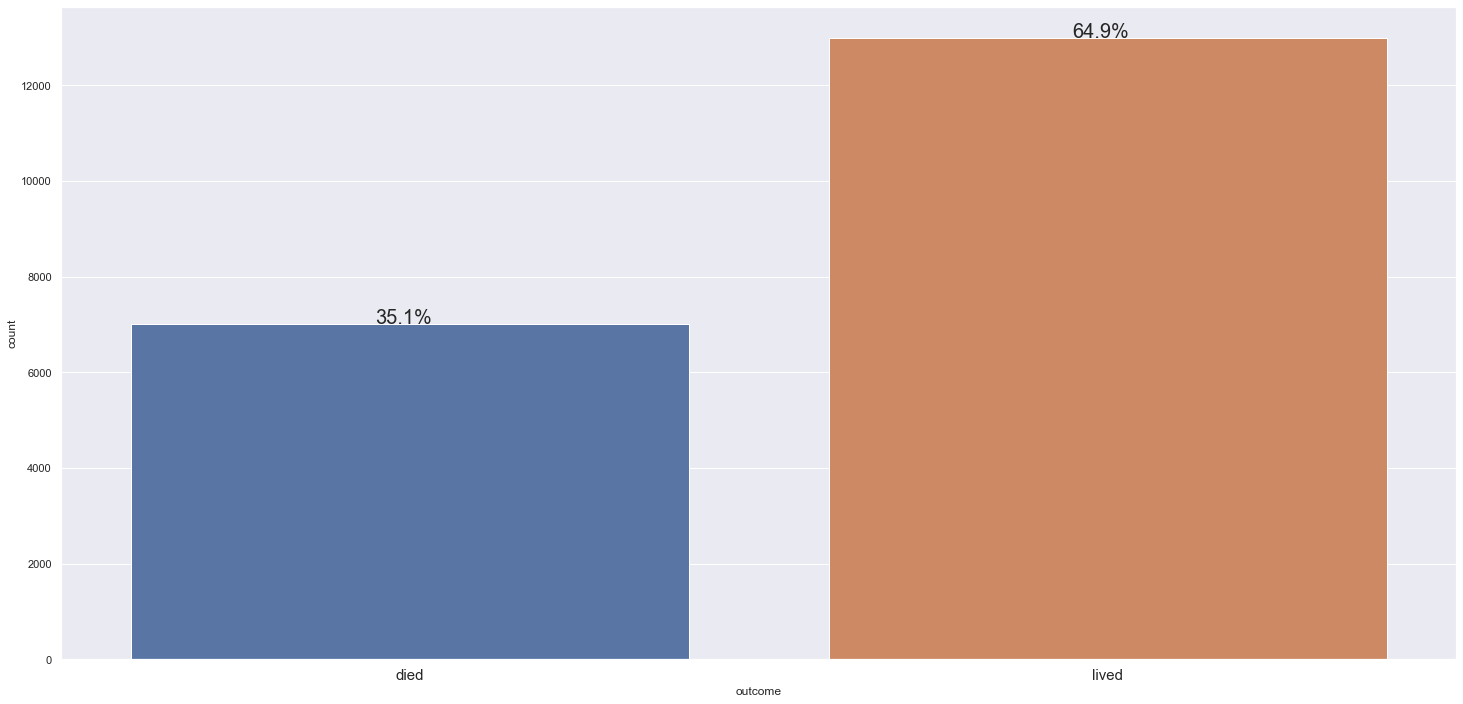

In [38]:
graphic = sns.countplot(df4['outcome'])
without_hue(graphic, df4['outcome'])

## 4.2 Univariate Analysis

### 4.2.1 Rectal_temp

<AxesSubplot:xlabel='rectal_temp'>

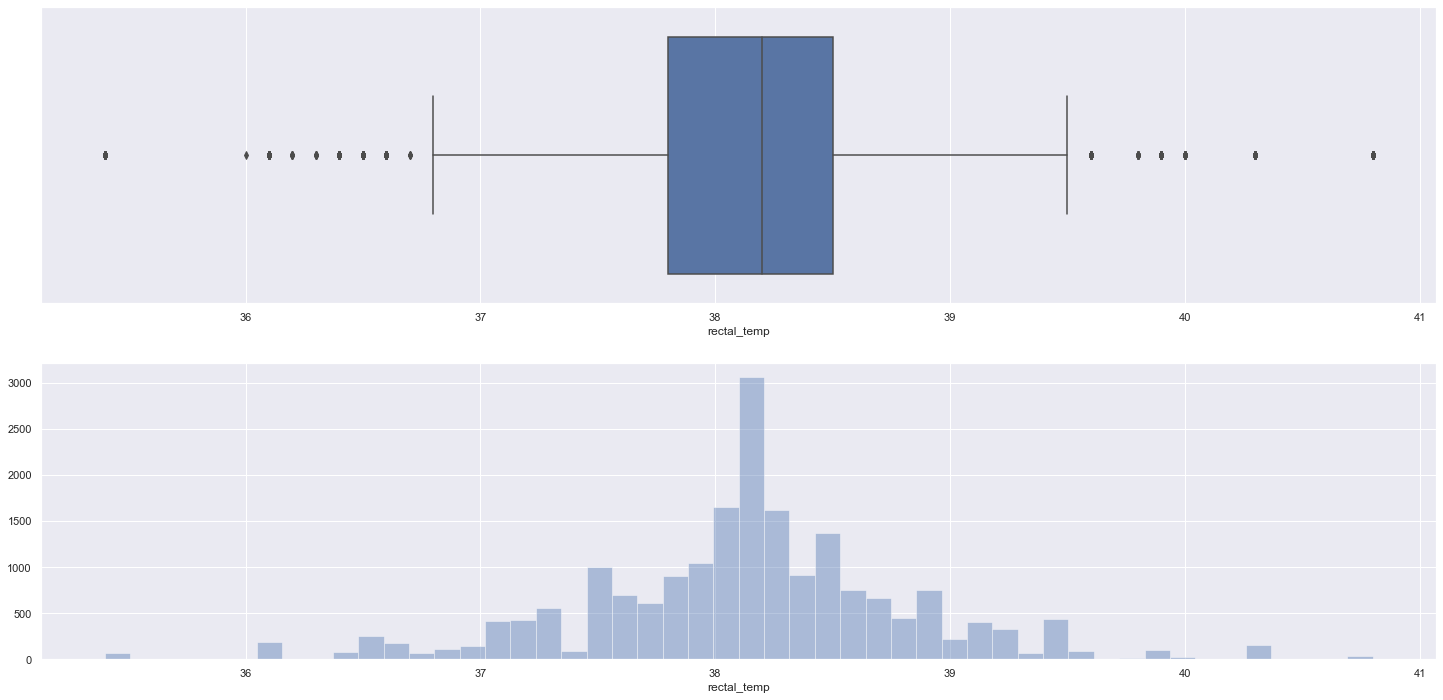

In [39]:
plt.subplot(2, 1, 1)
sns.boxplot(x = 'rectal_temp', data = df4)

plt.subplot(2, 1, 2)
sns.distplot(df4['rectal_temp'], kde=False)

### 4.2.2 Pulse

<AxesSubplot:xlabel='pulse'>

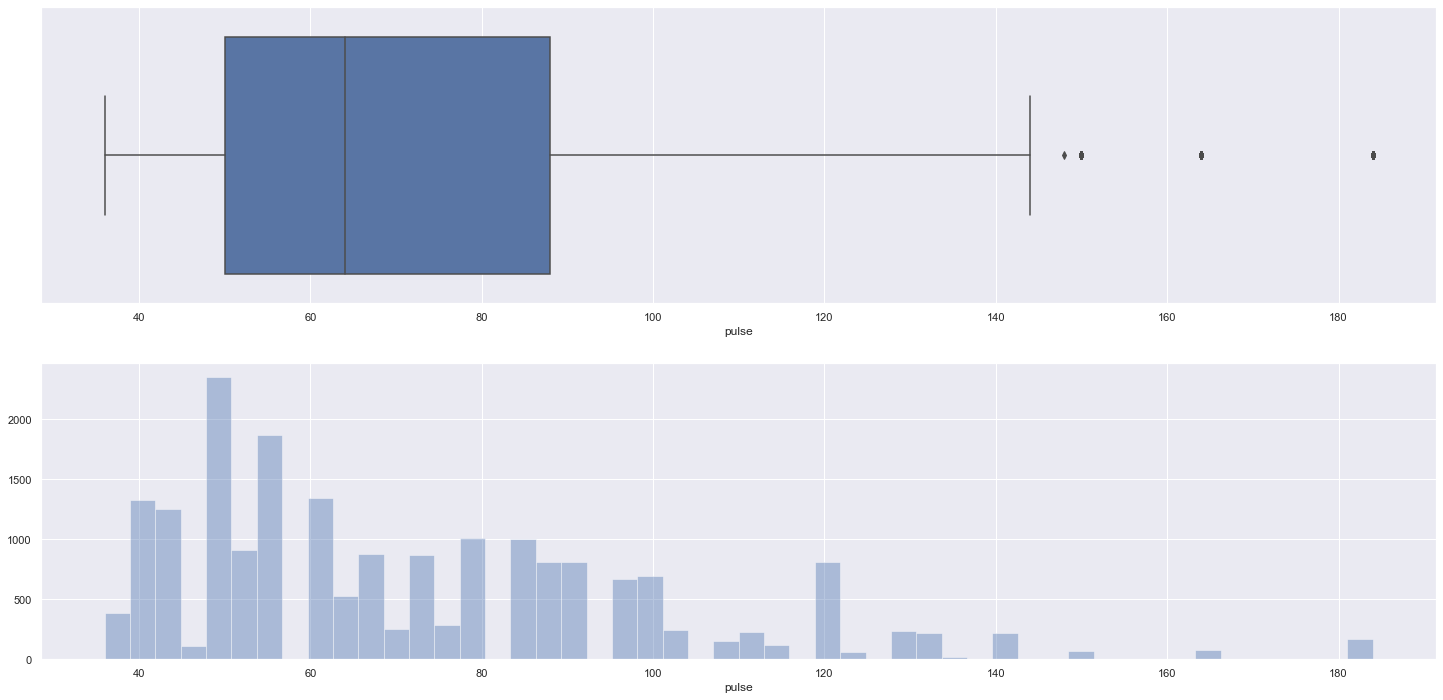

In [40]:
plt.subplot(2, 1, 1)
sns.boxplot(x = 'pulse' , data = df4)

plt.subplot(2, 1, 2)
sns.distplot(df4['pulse'], kde=False)

### 4.2.3 Packed_cell_volume

<AxesSubplot:xlabel='packed_cell_volume'>

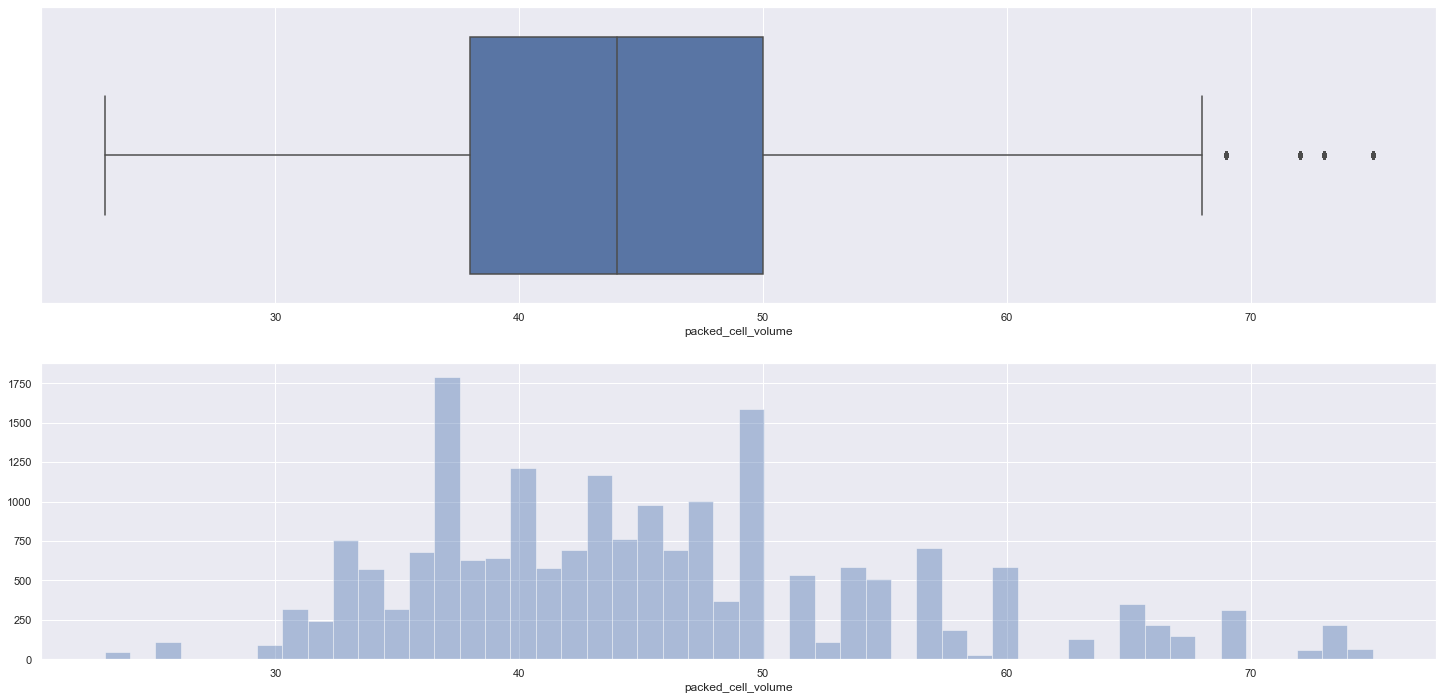

In [41]:
plt.subplot(2, 1, 1)
sns.boxplot(x = 'packed_cell_volume', data=df4)

plt.subplot(2, 1, 2)
sns.distplot(df4['packed_cell_volume'], kde=False)

### 4.2.4 total_protein

<AxesSubplot:xlabel='total_protein'>

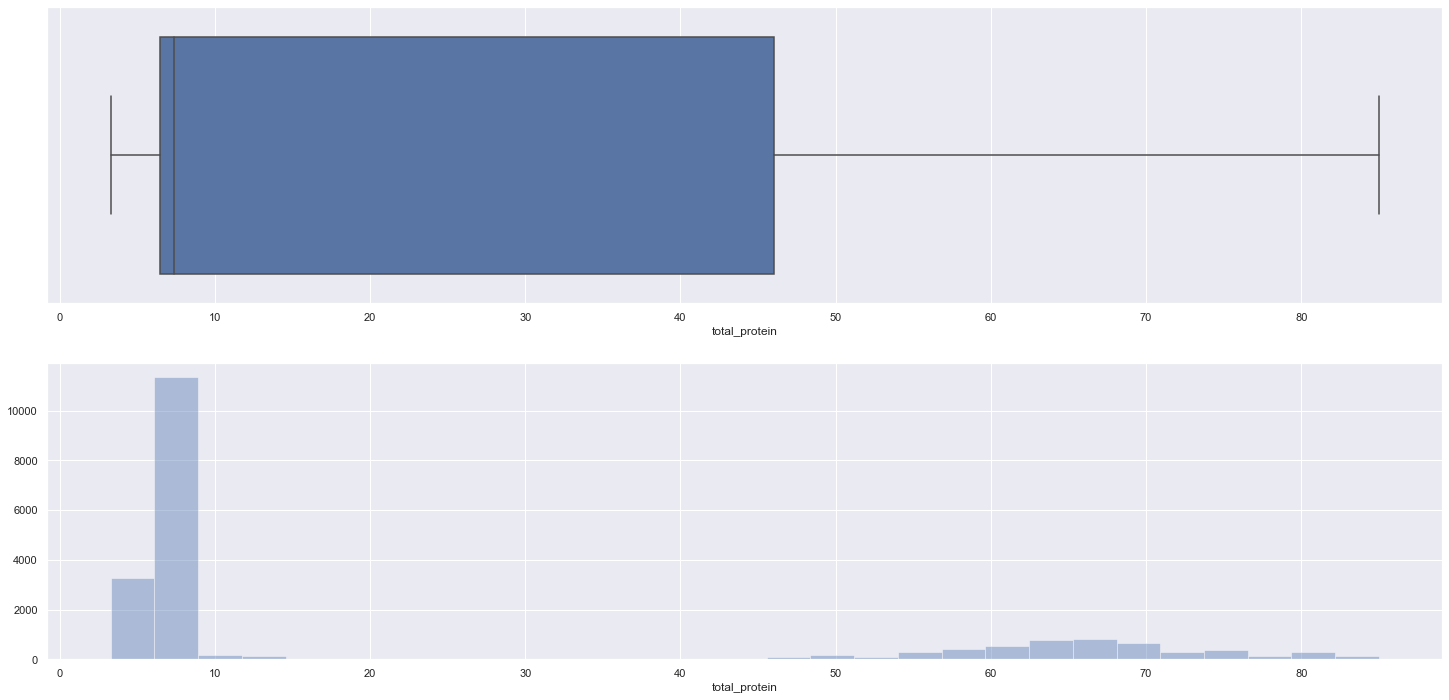

In [42]:
plt.subplot(2, 1, 1)
sns.boxplot(x = 'total_protein', data=df4)

plt.subplot(2, 1, 2)
sns.distplot(df4['total_protein'], kde=False)

## 4.3 Bivariate Analysis

### **H01** - There is a higher percentage of deaths among horses that have had surgery

*False* - However there is a small difference of only 0.4%

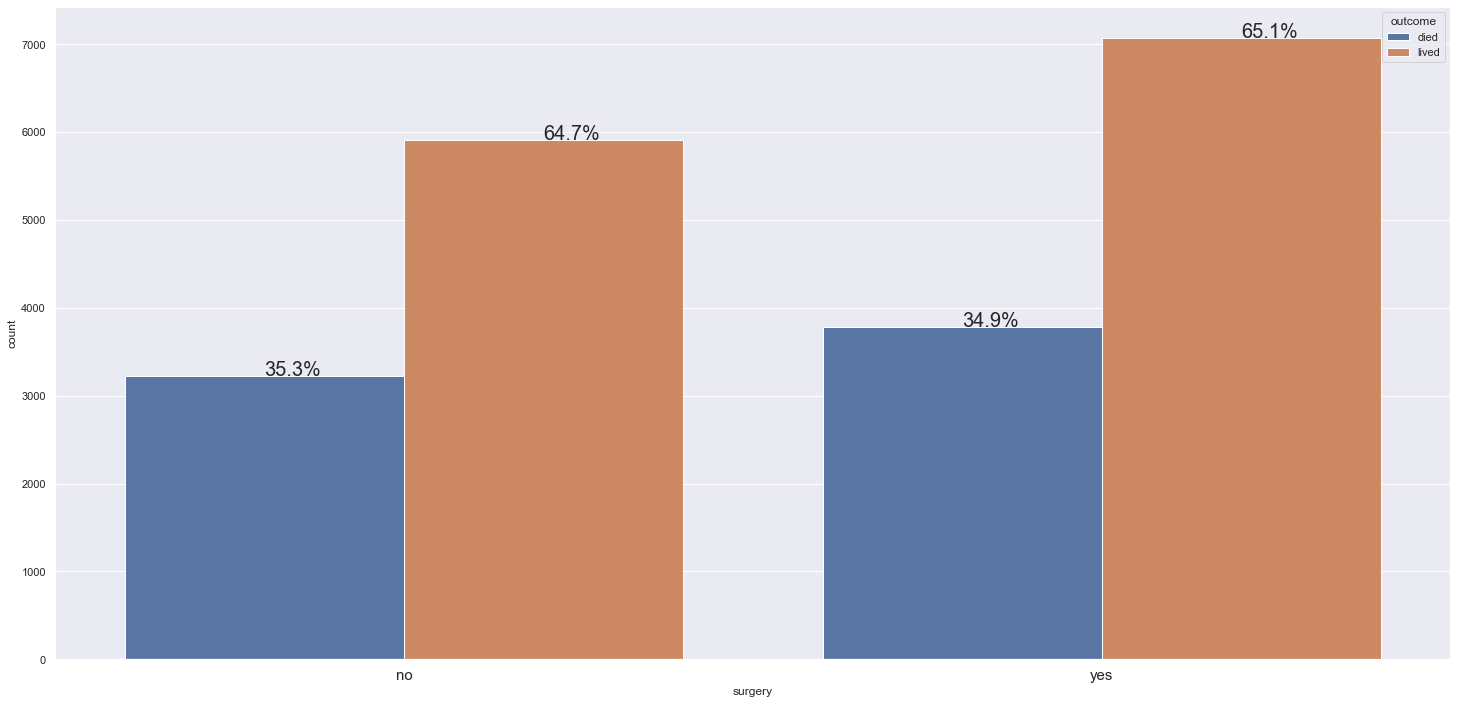

In [43]:
graphic = sns.countplot(x='surgery', data=df4, hue='outcome')
with_hue(graphic, df4['surgery'],2, 2)

### **H02** - There is a higher percentage of deaths among adult horses

*False* - Almost half of young horses have died and 66.2% of adult horses are alive

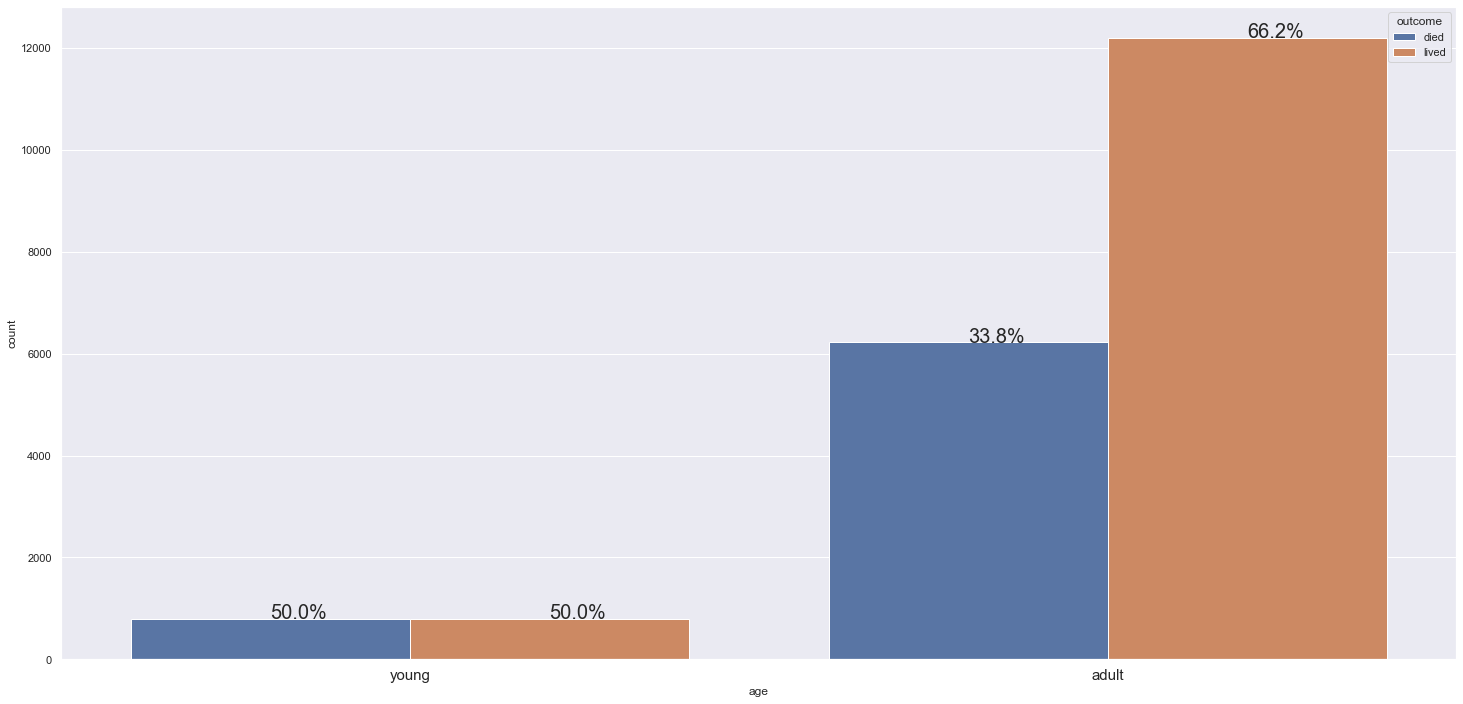

In [44]:
graphic = sns.countplot(x='age', data=df4, hue='outcome')
with_hue(graphic, df4['age'], 2, 2)

### **H03** - The lower the rectal temperature, lower the risk of death

*False* - There is almost the same distribution for live and dead horses according to rectal temperature

<AxesSubplot:xlabel='rectal_temp', ylabel='Density'>

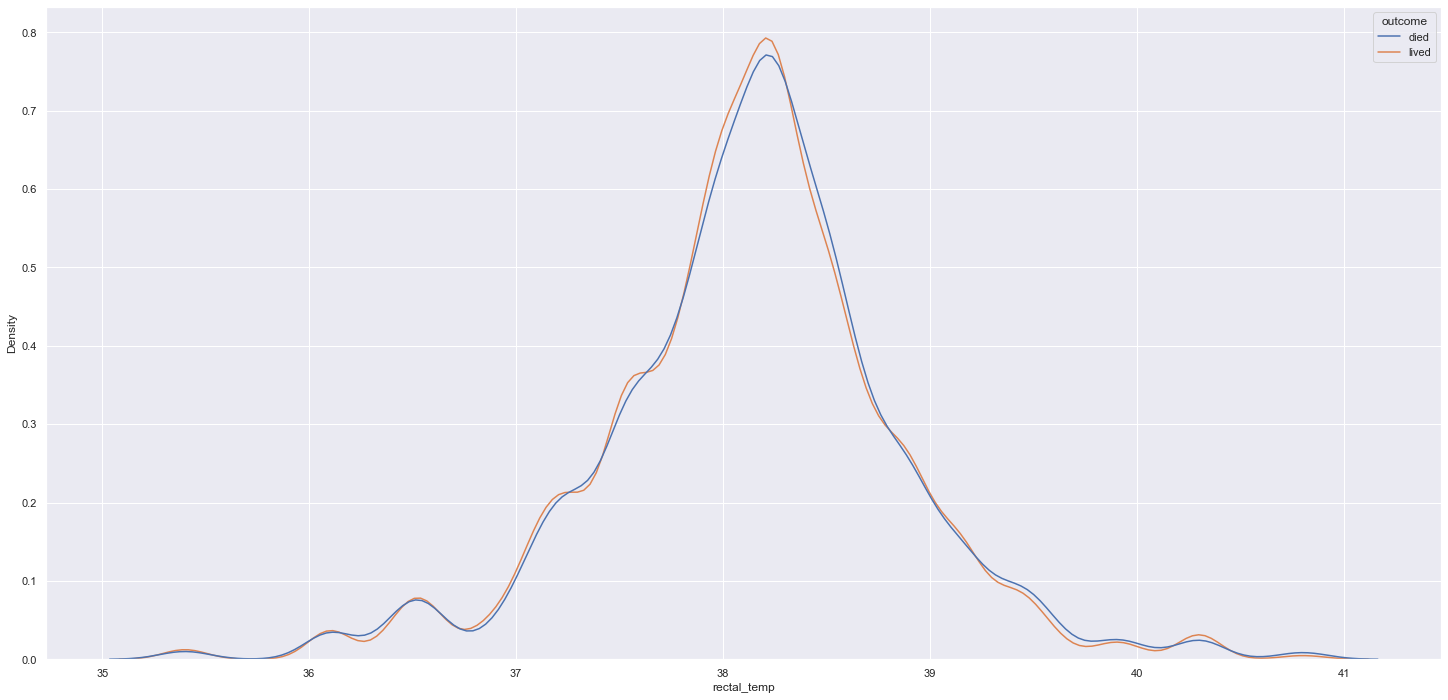

In [45]:
sns.kdeplot(data = df4, x='rectal_temp', hue='outcome', common_norm=False)


### **H04** - The higher the pulse, higher the risk of death

False - There is almost the same distribution for live and dead horses according to pulse

<AxesSubplot:xlabel='pulse', ylabel='Density'>

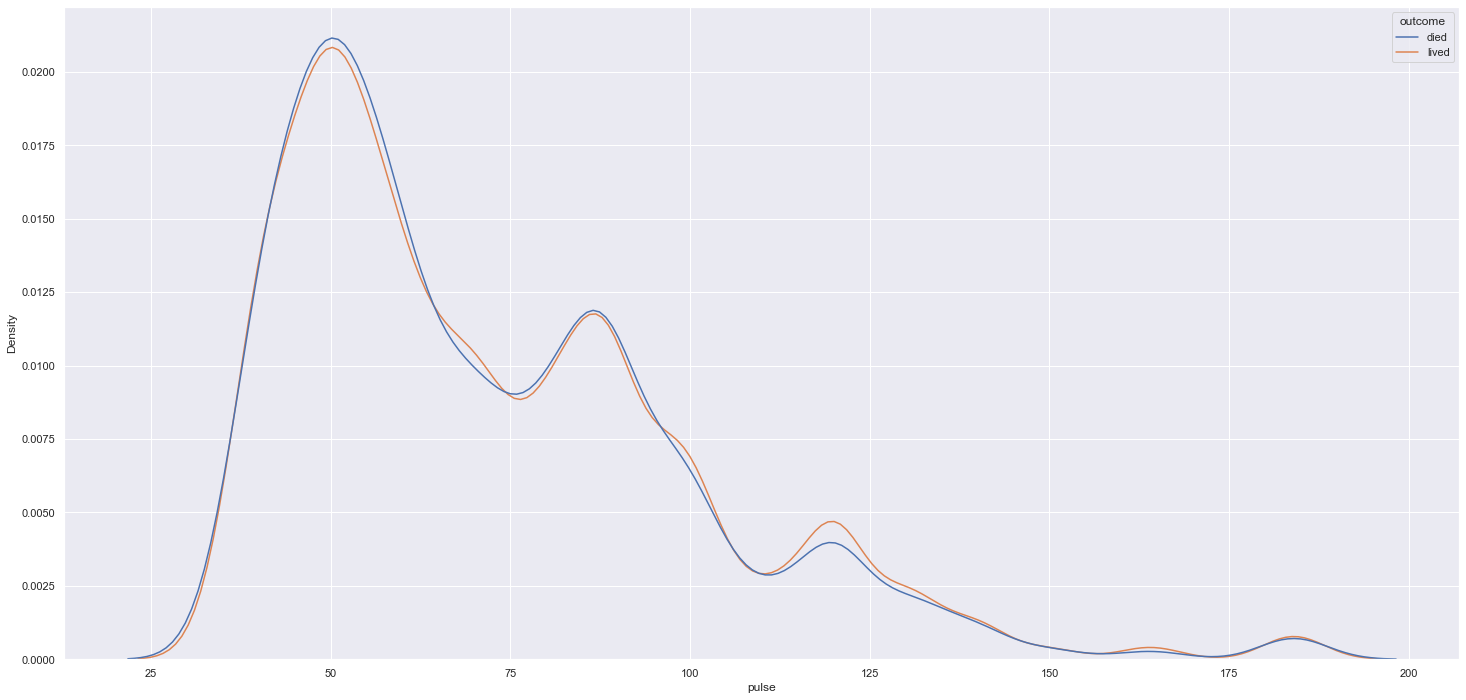

In [46]:
sns.kdeplot(data = df4, x='pulse', hue='outcome', common_norm=False)

### **H05** - There is a higher percentage of deaths among horses with cold temperature of extremities

*False* - The same percentage of horses with cold or normal temperature died, and there is almost the same percentage according to the temperature of extremities

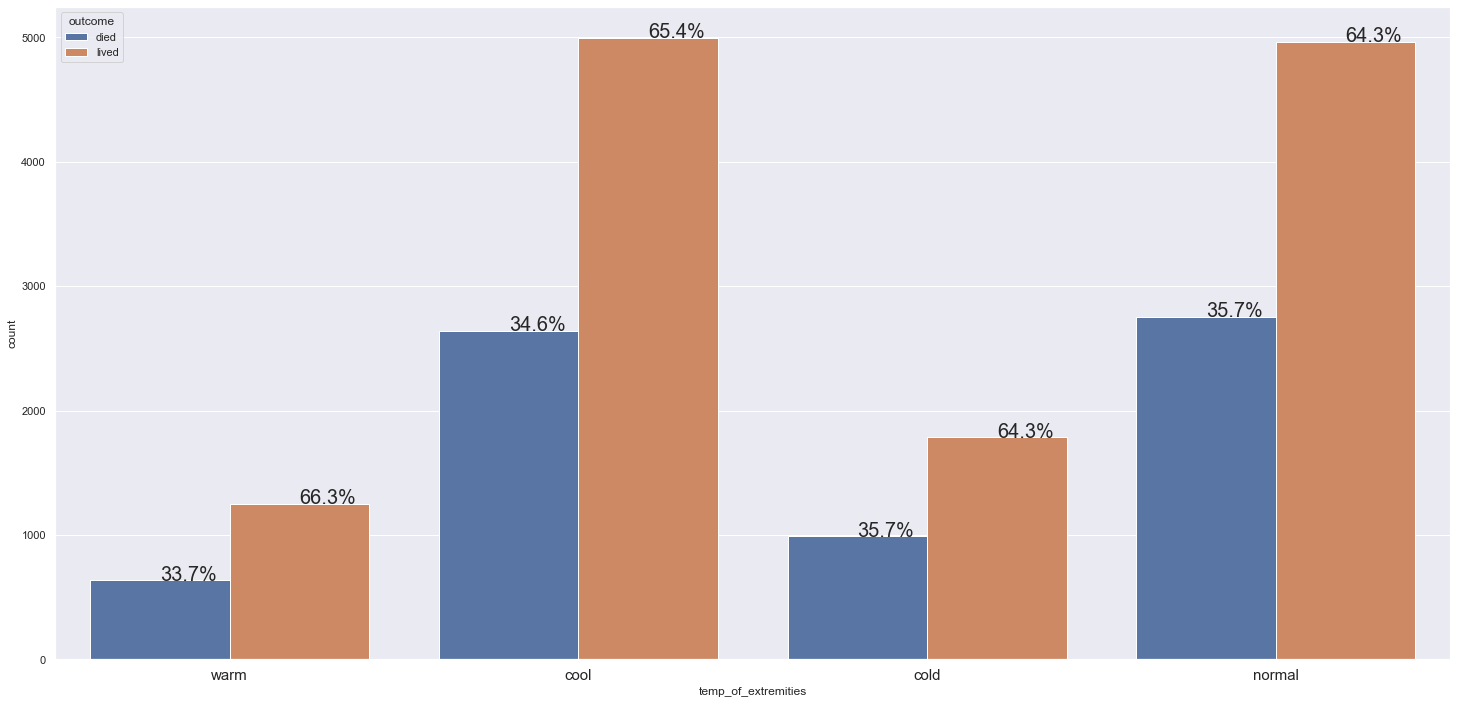

In [47]:
graphic = sns.countplot(x='temp_of_extremities', data=df4, hue='outcome')
with_hue(graphic, df4['temp_of_extremities'], 4, 2)

### **H06** - There is a higher percentage of deaths among horses with absent peripheral pulse

*True* - 36.2% of Horses with absent peripheral pulse died

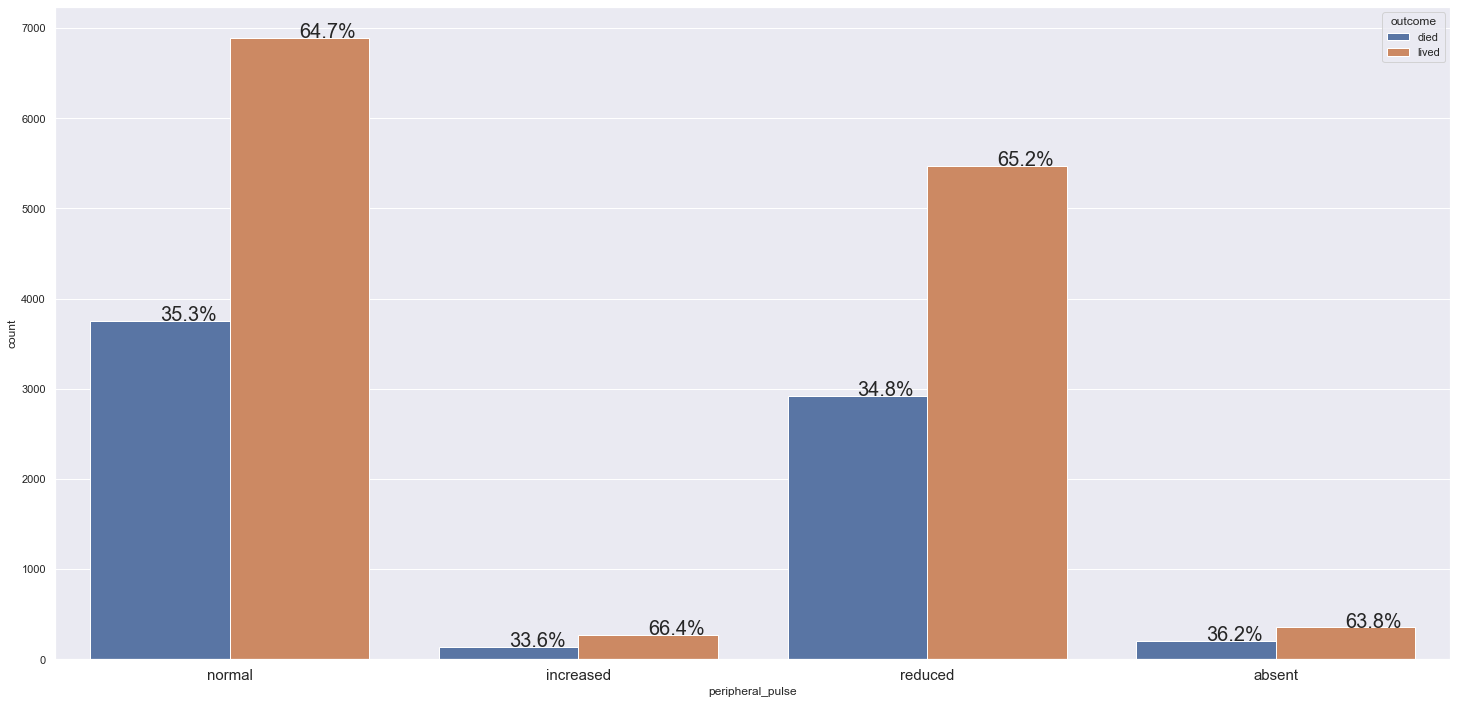

In [48]:
graphic = sns.countplot(x='peripheral_pulse', data=df4, hue='outcome')
with_hue(graphic, df4['peripheral_pulse'], 4, 2)

### **H07** - There is a higer percentage of deaths among horses with dark cyanotic mucous membrane

*False* - There is a higher percentage of deaths in horses with normal pink mucous membrane

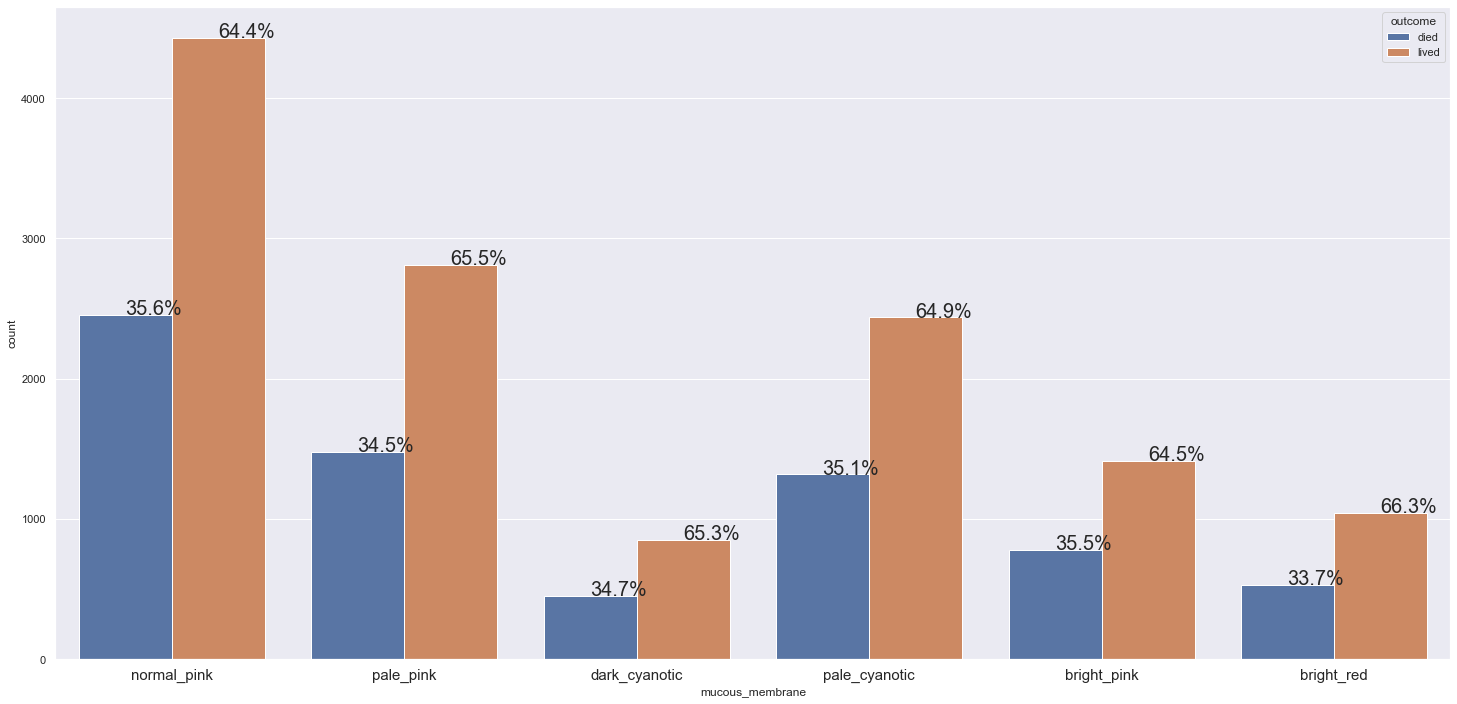

In [49]:
graphic = sns.countplot(x='mucous_membrane', data=df4, hue='outcome')
with_hue(graphic, df4['mucous_membrane'], 6, 2)

### **H08** - There is a higher percentage of deaths among horses with a higher capillary refill time value.

*False* - There is almost the same percentage of deaths for different capillary refill time values

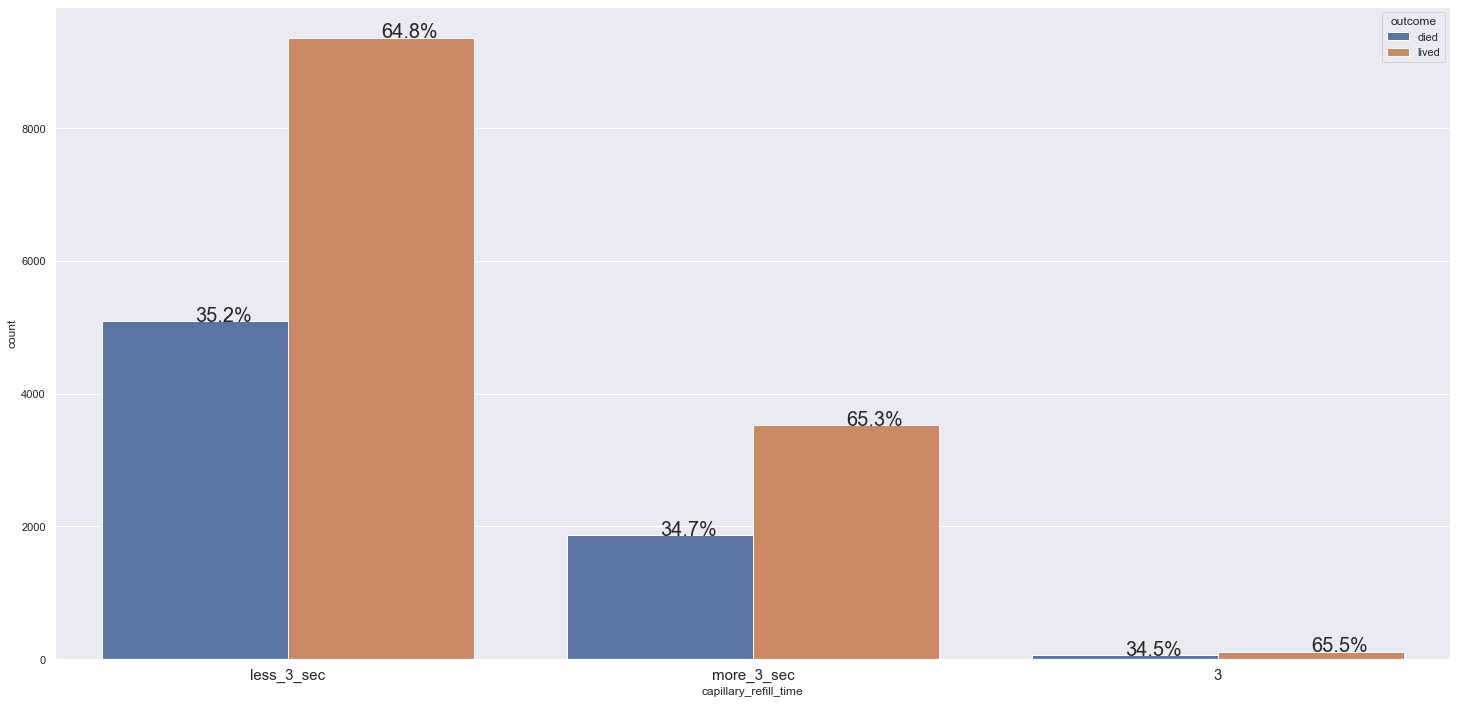

In [50]:
graphic = sns.countplot(x='capillary_refill_time', data=df4, hue='outcome')
with_hue(graphic, df4['capillary_refill_time'], 3, 2)

### **H09** - The greater the pain indicators, higher the risk of death

*False* - There is almost the same percentage of deaths for different levels of pain

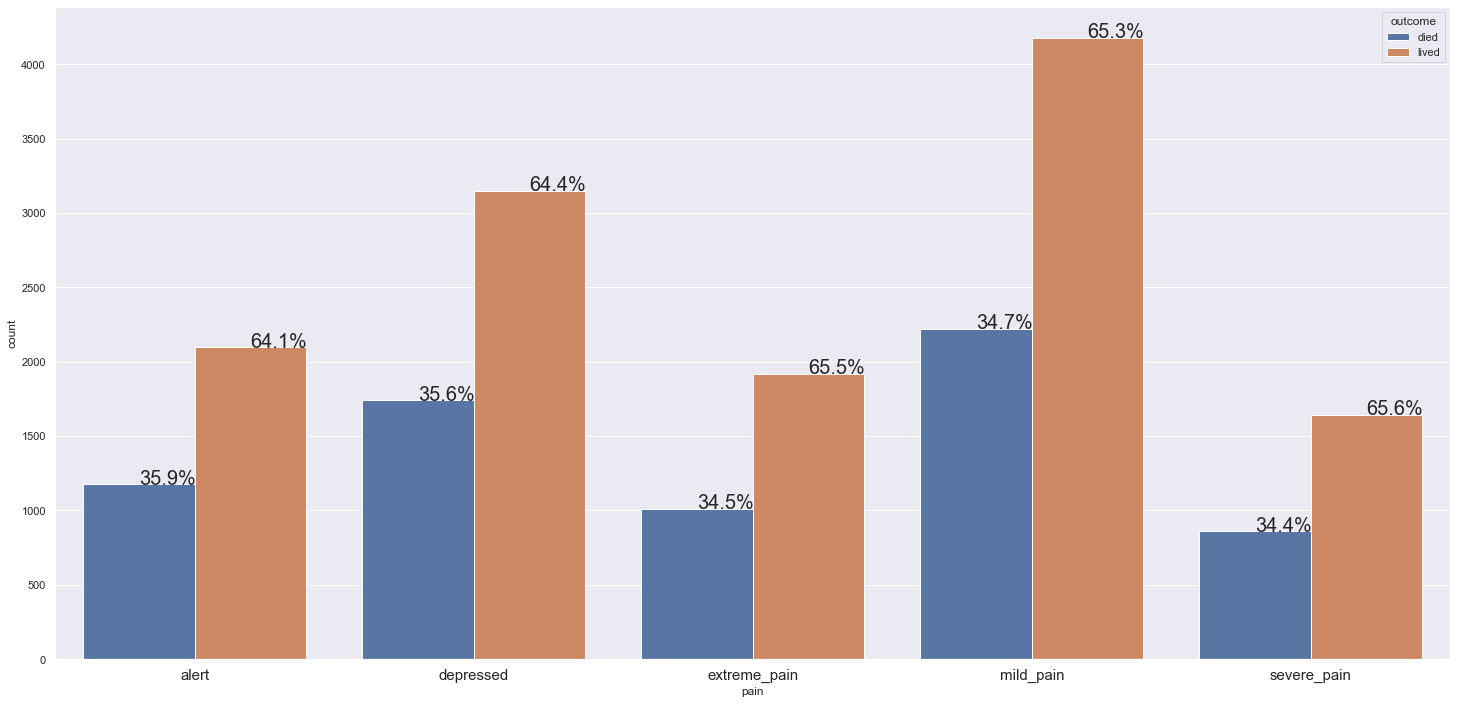

In [51]:
graphic = sns.countplot(x='pain', data=df4, hue='outcome')
with_hue(graphic, df4['pain'], 5, 2)

### **H10** - There is a higher percentage of deaths among horses with hypomotile peristalsis

*False* - There is a higher percentage of death in horses with normal peristalsis

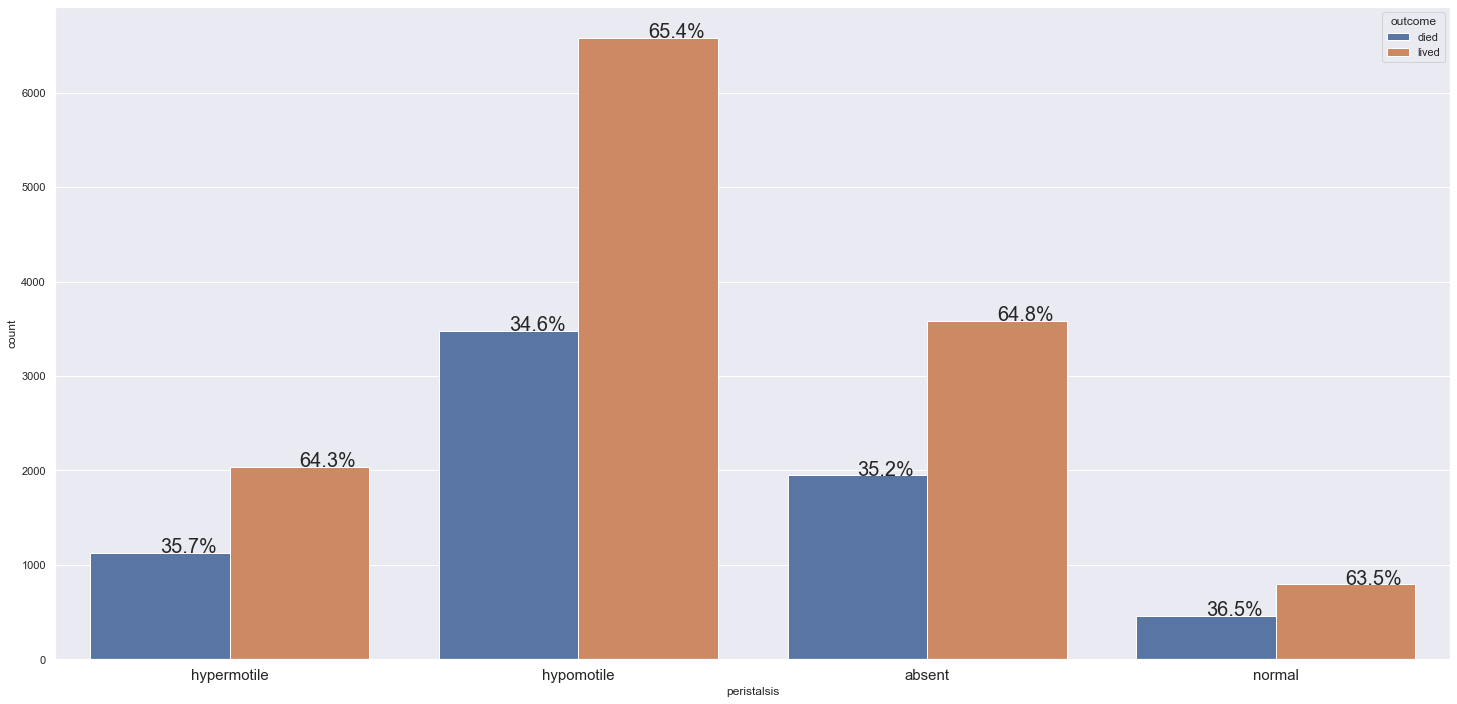

In [52]:
graphic = sns.countplot(x='peristalsis', data=df4, hue='outcome')
with_hue(graphic, df4['peristalsis'], 4, 2)

### **H11** - There is a higher percentage of deaths among horses with severe abdominal distention

*True* - Among the horses with severe abdominal distention the percentage of death is 37%

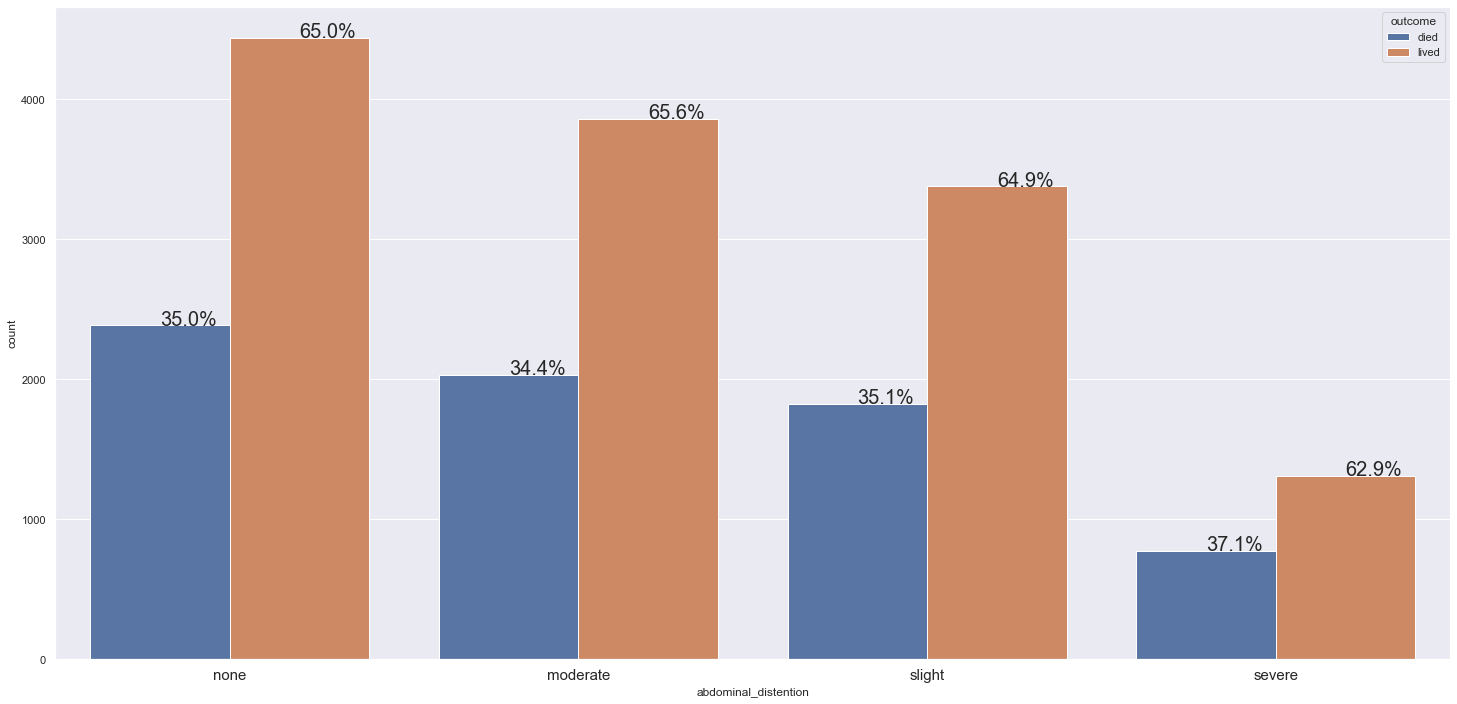

In [53]:
graphic = sns.countplot(x='abdominal_distention', data=df4, hue='outcome')
with_hue(graphic, df4['abdominal_distention'], 4, 2)

### **H12** - When there is no nasogastric gas the risk of death is lower

*True* - Among the horses that did not have nasogastric gas the percentage of death is 34.5%

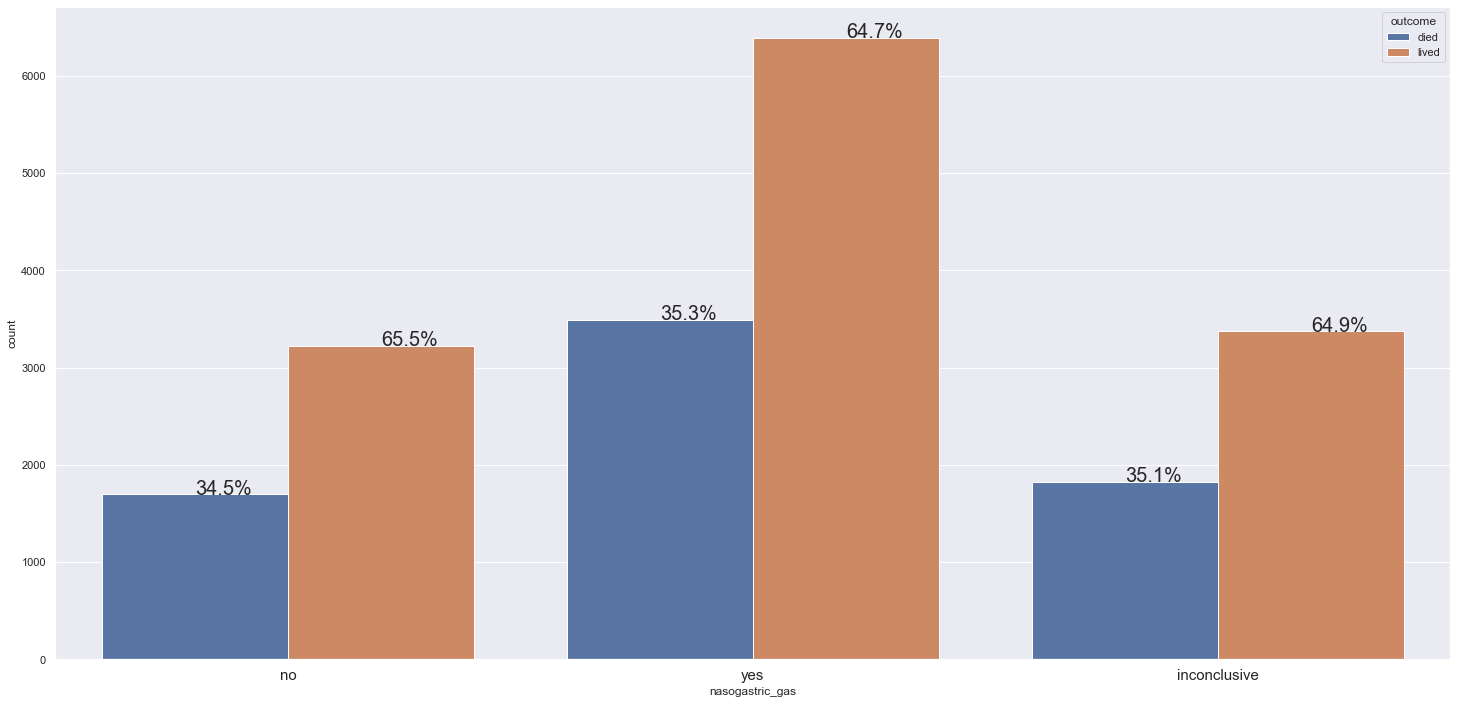

In [54]:
df_aux = df4[['nasogastric_tube', 'outcome']].copy()
df_aux['nasogastric_gas'] = df_aux['nasogastric_tube'].apply(lambda x: 'yes' if ((x==2) | (x==3)) else 'no' if x==1 else 'inconclusive')

graphic = sns.countplot(x='nasogastric_gas', data=df_aux, hue='outcome')
with_hue(graphic, df_aux['nasogastric_tube'], 3, 2)

### **H13** - When there is no nasogastric reflux, the risk of death is lower

*False* - Without nasogastric reflux the percentage of death was higher

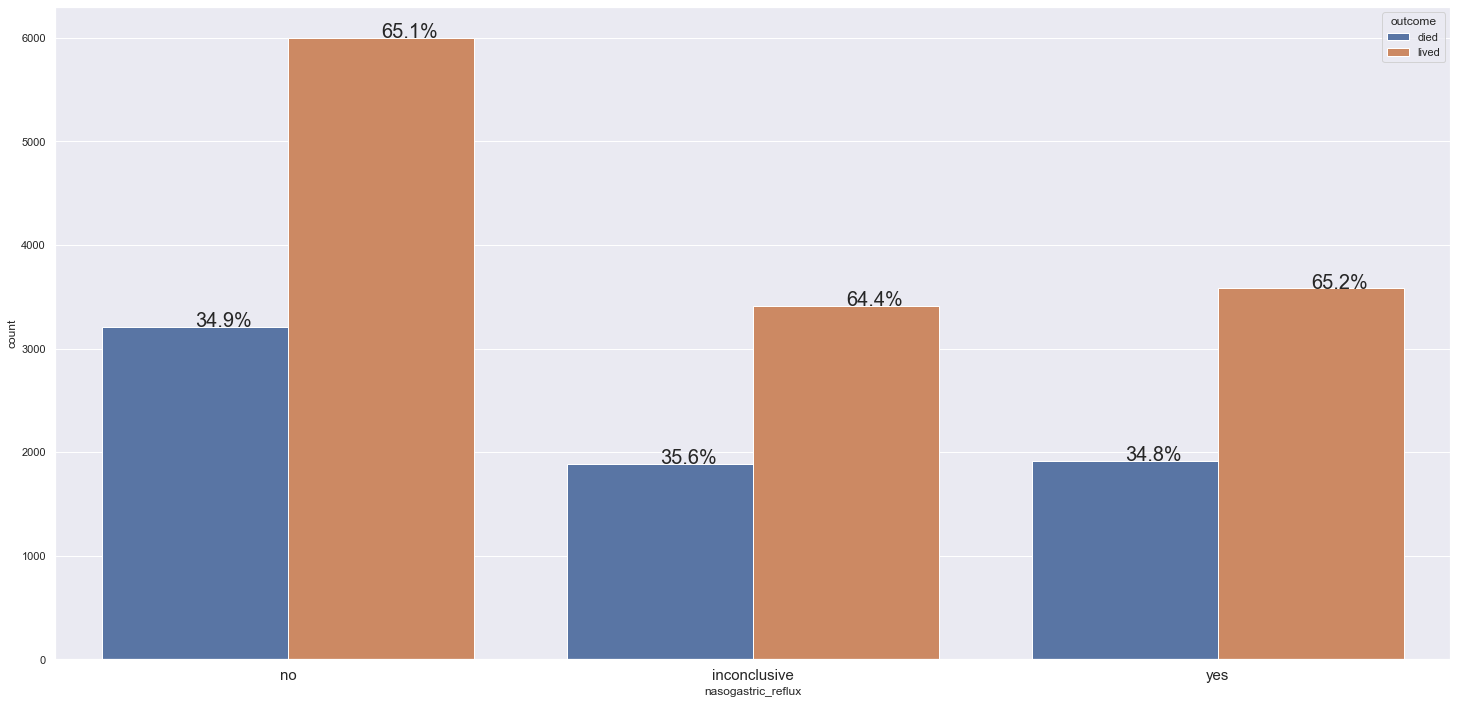

In [55]:
df_aux = df4[['nasogastric_reflux', 'outcome']].copy()
df_aux['nasogastric_reflux'] = df_aux['nasogastric_reflux'].apply(lambda x: 'yes' if ((x==2) | (x==3)) else 'no' if x==1 else 'inconclusive')

graphic = sns.countplot(x='nasogastric_reflux', data=df_aux, hue='outcome')
with_hue(graphic, df_aux['nasogastric_reflux'], 3, 2)

### **H14** - There is a higher percentage of deaths among horses with a nasogastric reflux ph greater than 4

*False* - The risk of death is higher when the nasogastric reflux ph is between 3 and 4

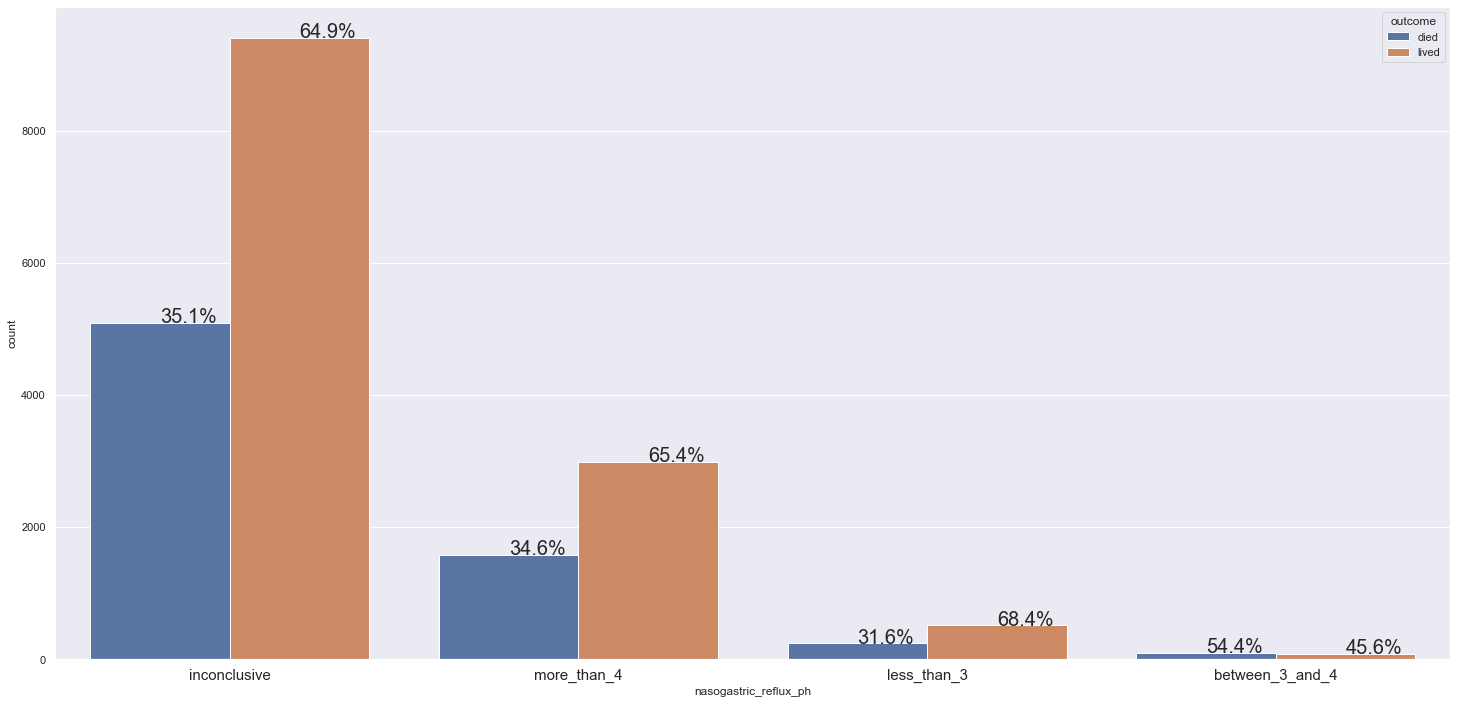

In [56]:
df_aux = df4[['nasogastric_reflux_ph', 'outcome']].copy()
df_aux['nasogastric_reflux_ph'] = df_aux['nasogastric_reflux_ph'].apply(lambda x: 'less_than_3' if x==1 else 'between_3_and_4' if x==2 else 'more_than_4' if x==3 else 'inconclusive')

graphic = sns.countplot(x='nasogastric_reflux_ph', data=df_aux, hue='outcome')
with_hue(graphic, df_aux['nasogastric_reflux_ph'], 4, 2)

### **H15** - There is a higher percentage of deaths among horses with firm abdomen

*False* - There is a higher percentage of deaths among horses with normal abdomen

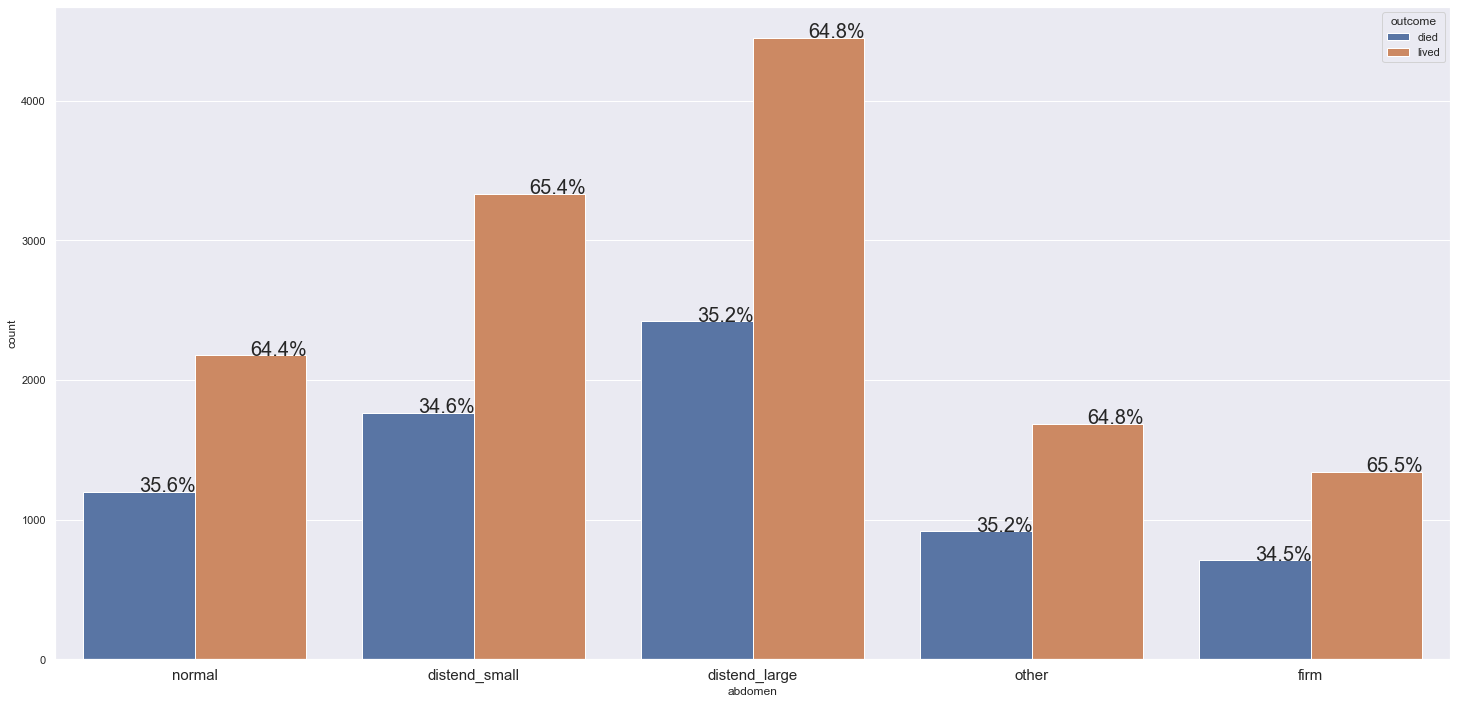

In [57]:
graphic = sns.countplot(x='abdomen', data=df4, hue='outcome')
with_hue(graphic, df4['abdomen'], 5, 2)

### **H16** - The larger the packed cell volume, higher the risk of death

*False* - There is almost the same distribution for live of dead horses according to the packed cell volume

<AxesSubplot:xlabel='packed_cell_volume', ylabel='Density'>

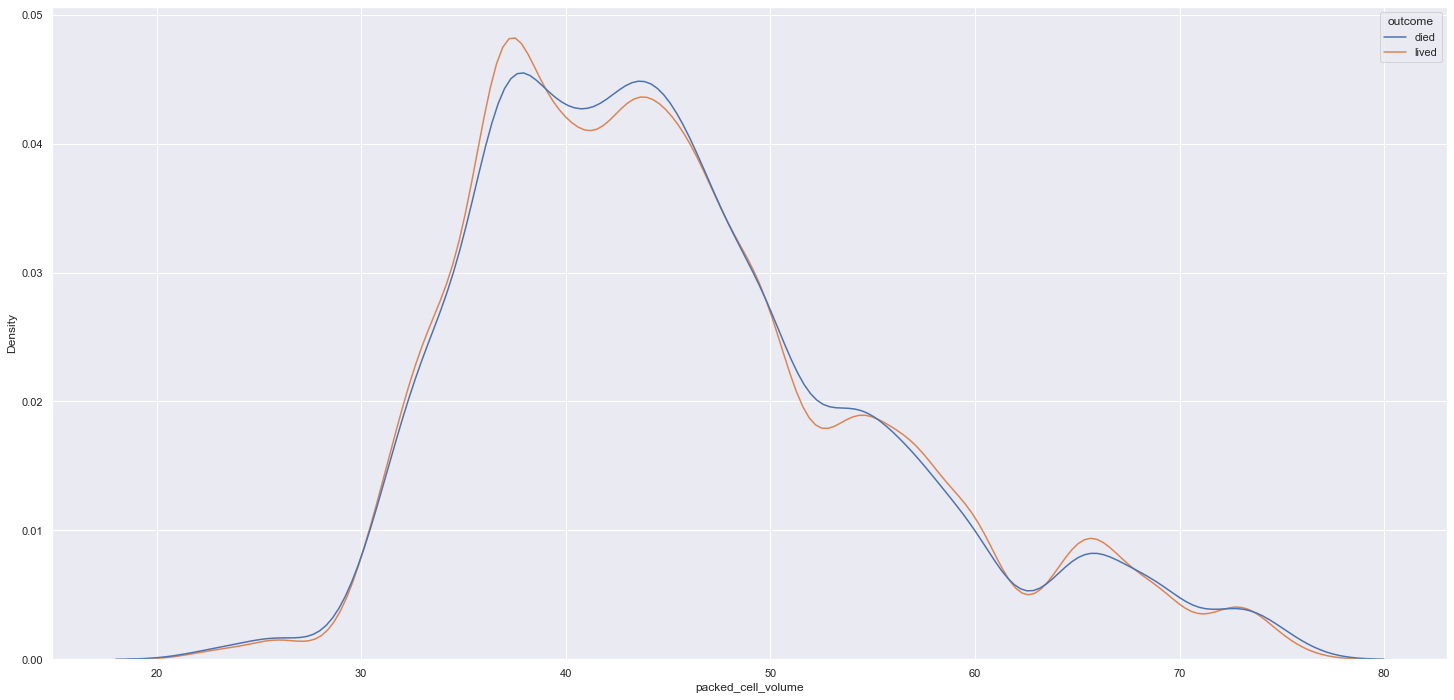

In [58]:
sns.kdeplot(data=df4, x='packed_cell_volume', hue='outcome', common_norm=False)

### **H17** - There is a higher percentage of death among horses with a total protein greater than 10 (gms/dL)

*False* - The risk of death is higher when the total protein value is less than 10 (gms/dL) 

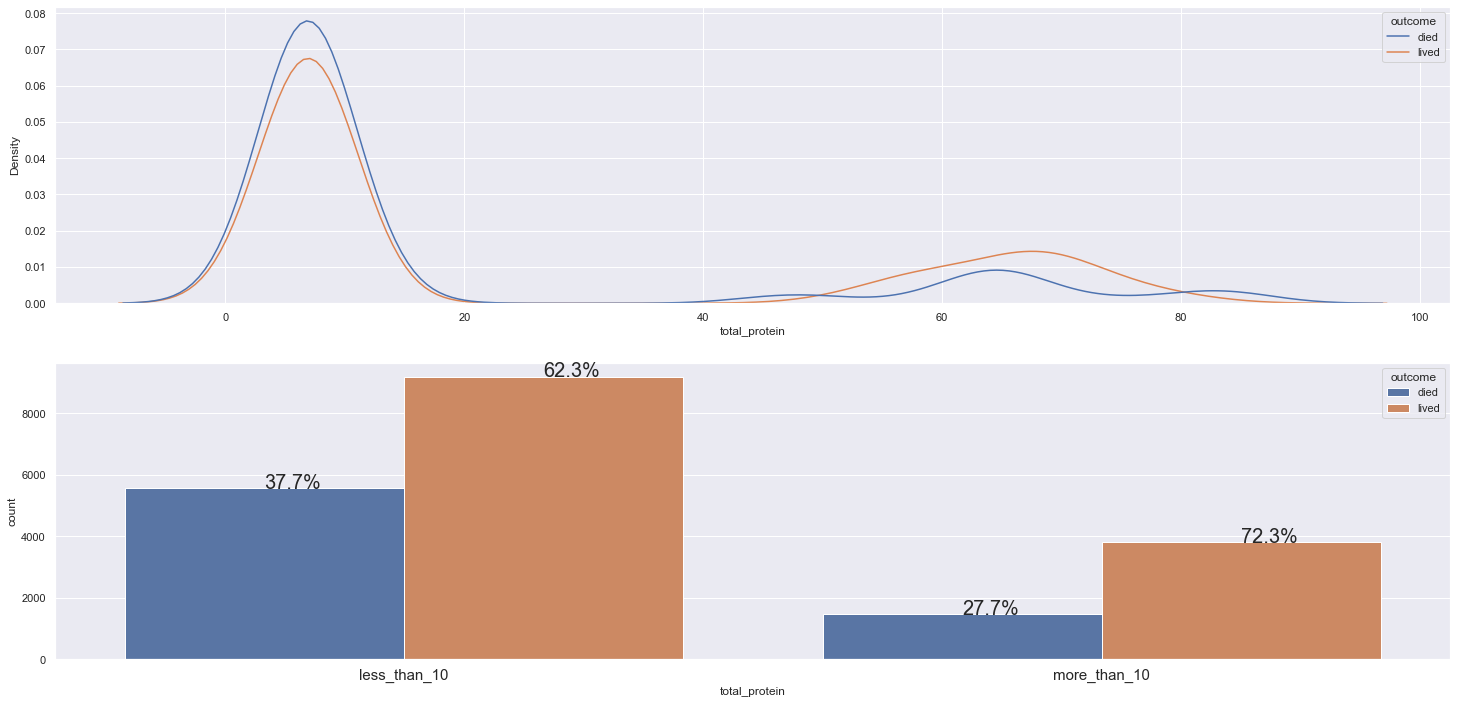

In [59]:
df_aux = df4[['total_protein', 'outcome']].copy()
df_aux['total_protein'] = df_aux['total_protein'].apply(lambda x: 'less_than_10' if x<10 else 'more_than_10')

plt.subplot(2, 1, 1)
sns.kdeplot(data=df4, x='total_protein', hue='outcome', common_norm=False)

plt.subplot(2, 1, 2)
graphic = sns.countplot(x='total_protein', data=df_aux, hue='outcome')
with_hue(graphic, df_aux['total_protein'], 2, 2)

### **H18** - There is a higher percentage of deaths among horses with serosanguious abdomo appearance

*True* - The percentage of deaths among horses with serosanguious abdomo appearance is 52.3%

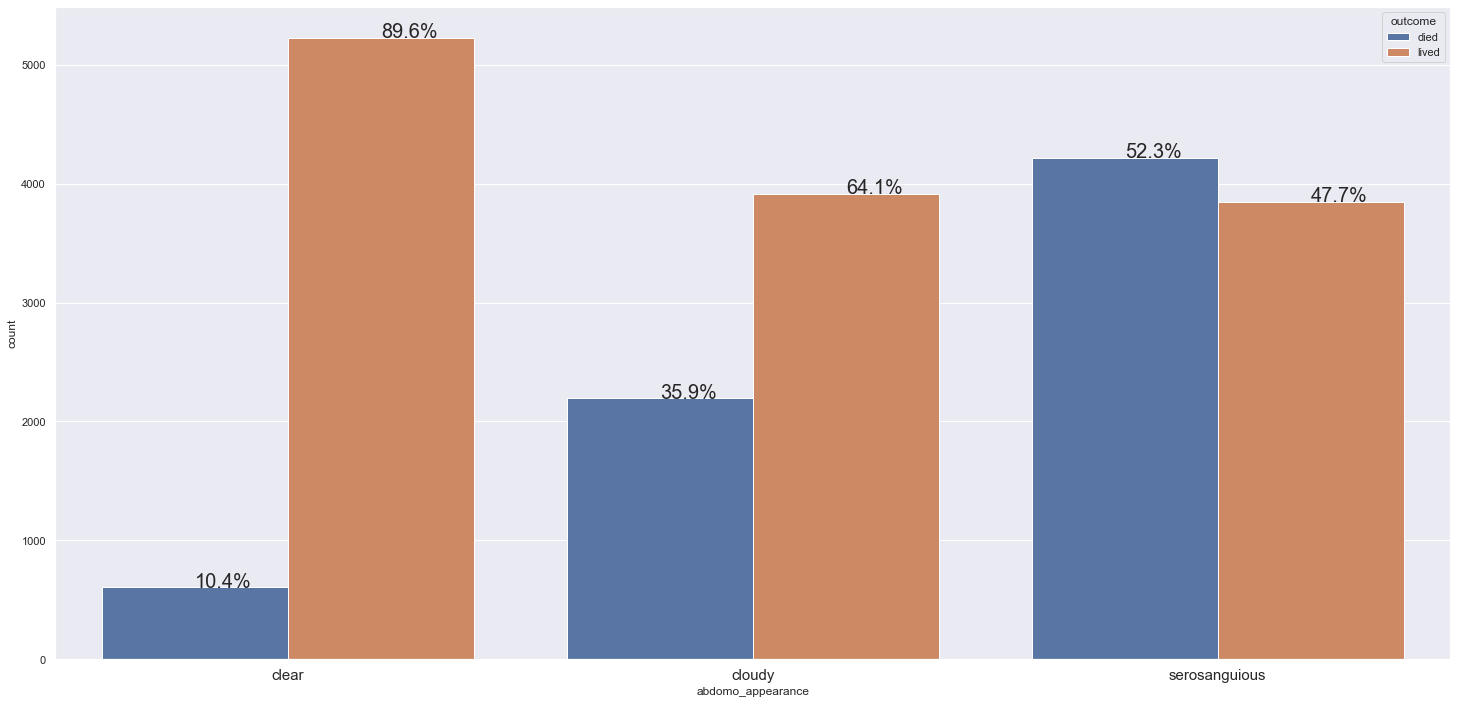

In [60]:
graphic = sns.countplot(x='abdomo_appearance', data=df4, hue='outcome')
with_hue(graphic, df4['abdomo_appearance'], 3, 2)

### **H19** - There is a higher percentage of deaths among horses with surgical lesion

*False* - The percentage of death among horses without surgical lesion is higher

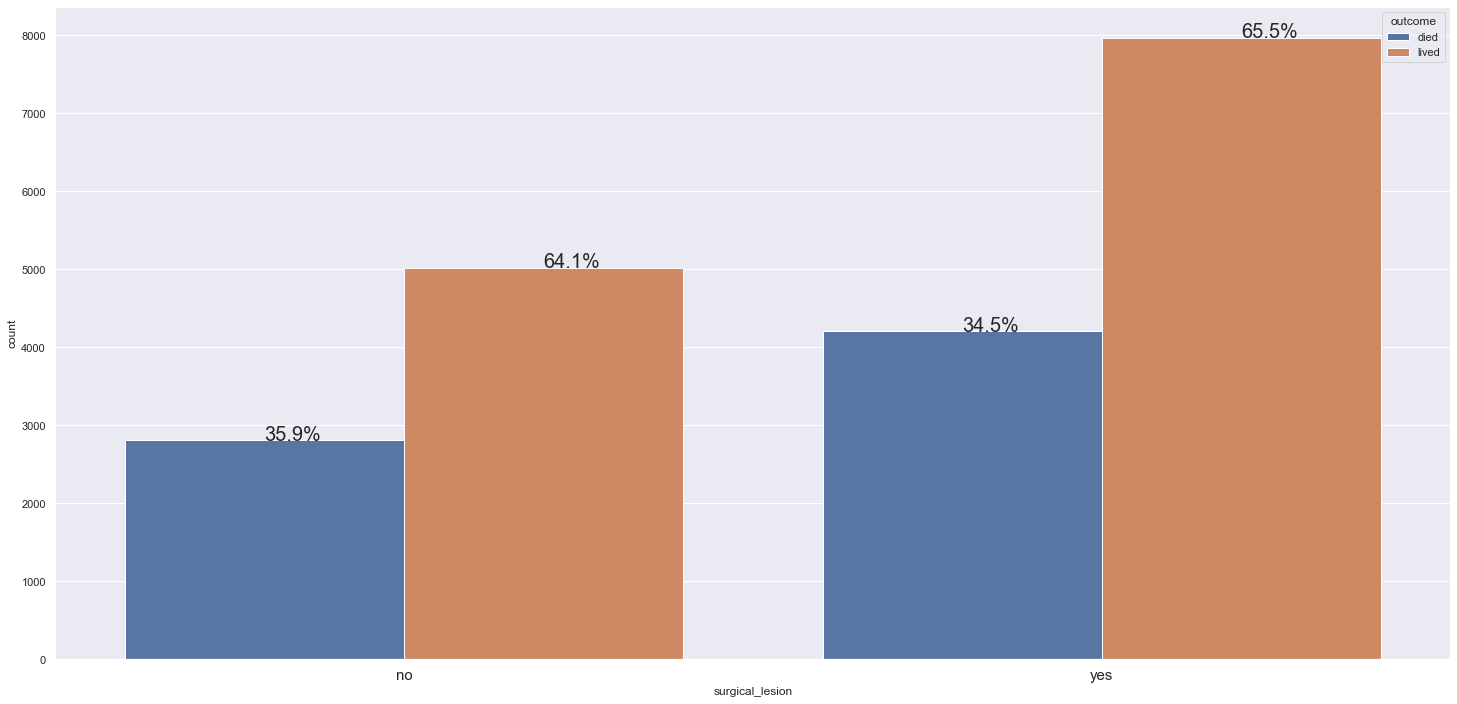

In [61]:
graphic = sns.countplot(x='surgical_lesion', data=df4, hue='outcome')
with_hue(graphic, df4['surgical_lesion'], 2, 2)

### **H20** - There is a higher percentage of deaths among horses that had lesion type 1

*False* - The percentage of death is higher among horses without lesion type 1

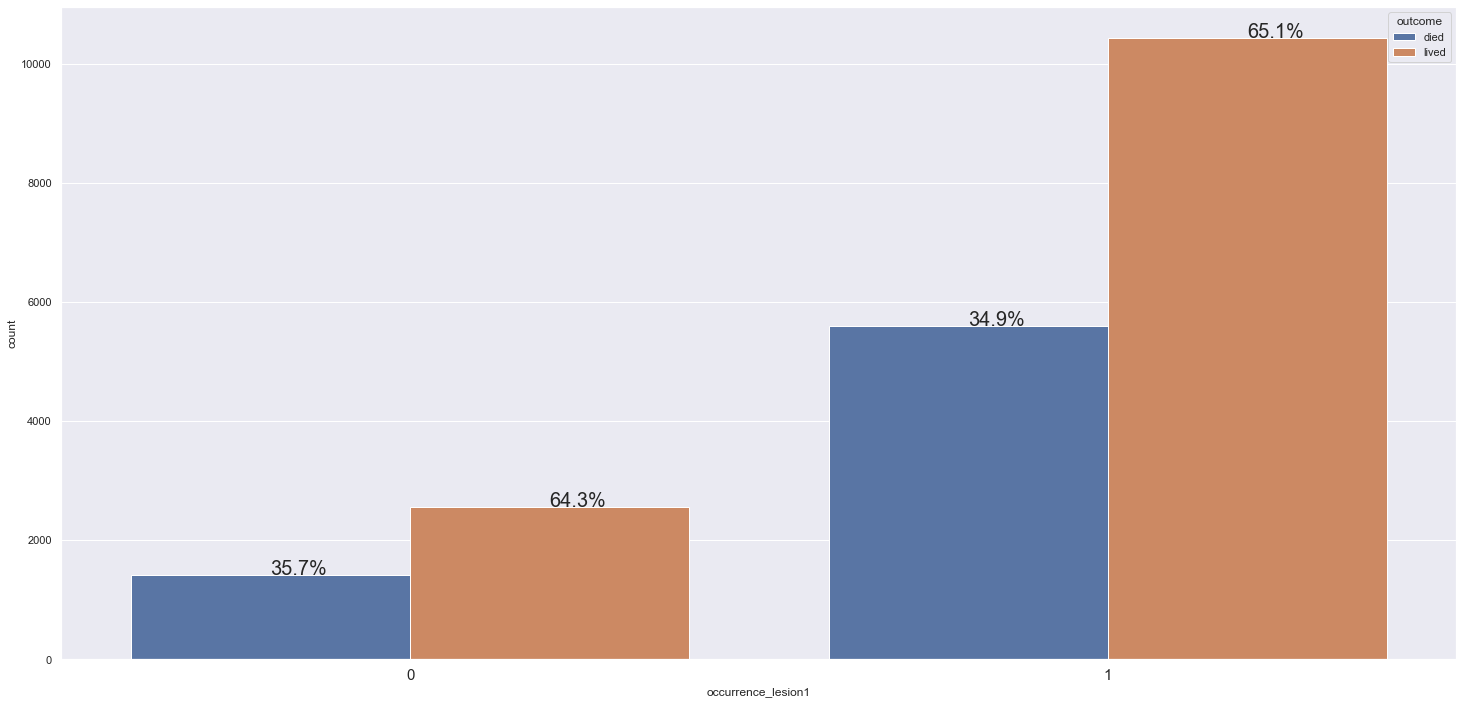

In [62]:
graphic = sns.countplot(x='occurrence_lesion1', data=df4, hue='outcome')
with_hue(graphic, df4['occurrence_lesion1'], 2, 2)

### **H21** - There is a higher percentage of deaths among horses that had lesion_2

*False* - The percentage of death is higher among horses without lesion type 2

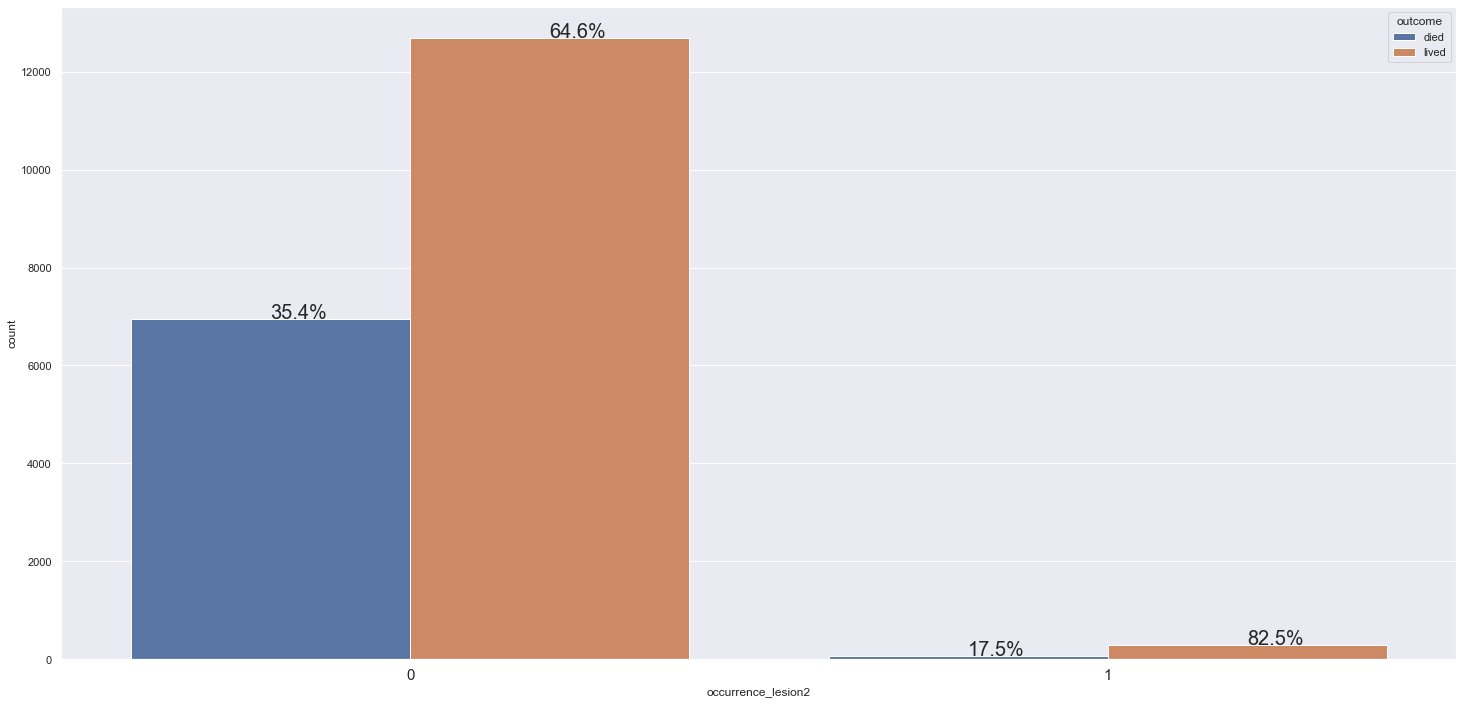

In [63]:
graphic = sns.countplot(x='occurrence_lesion2', data=df4, hue='outcome')
with_hue(graphic, df4['occurrence_lesion2'], 2, 2)

### **H22** - The risk of death is lower when the pathology data is present

*True* - When the pathology data is present the risk of death is 32.4%

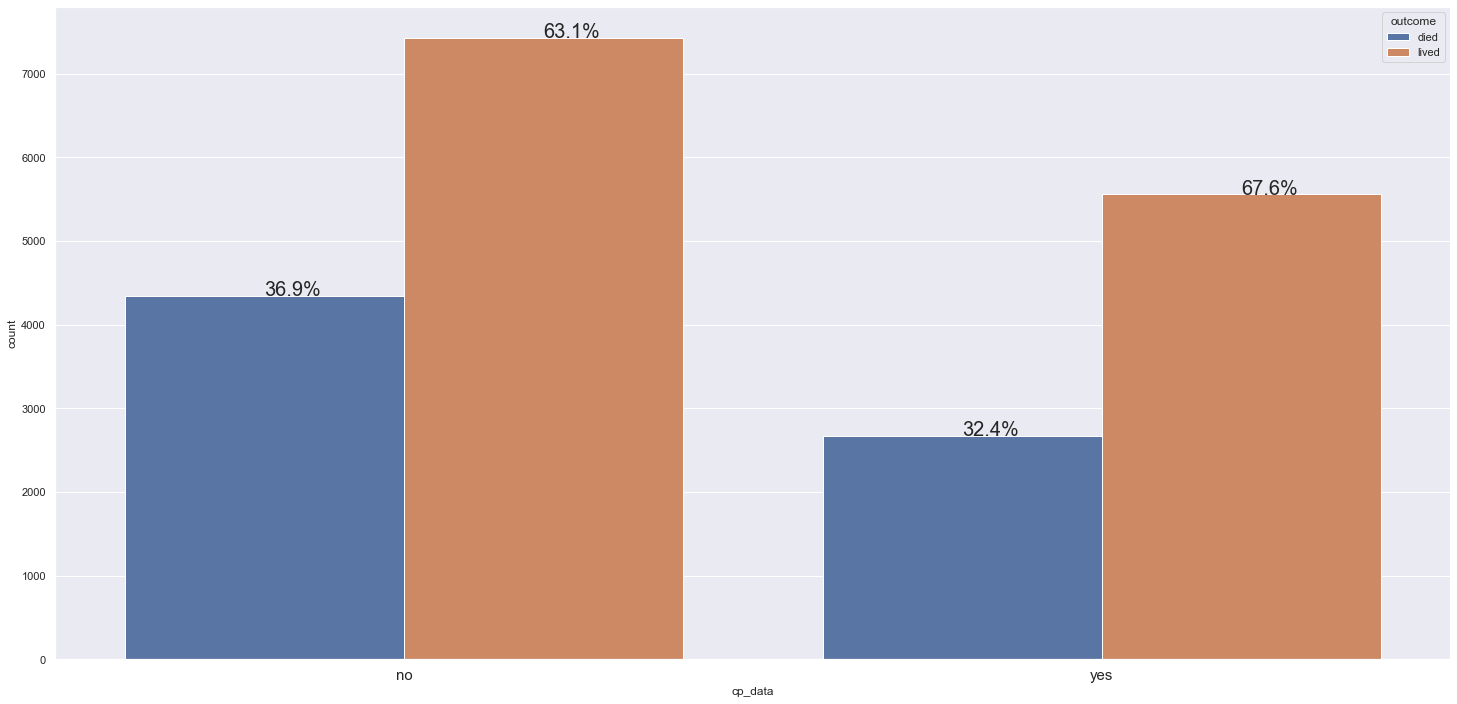

In [64]:
graphic = sns.countplot(x='cp_data', data=df4, hue='outcome')
with_hue(graphic, df4['cp_data'], 2, 2)

# 5.0 Data Preparation

In [65]:
df5 = df4.copy()

In [66]:
df5.head()

,surgery,age,rectal_temp,pulse,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,abdomen,packed_cell_volume,total_protein,abdomo_appearance,outcome,surgical_lesion,lesion_1,lesion_2,cp_data,occurrence_lesion1,occurrence_lesion2
0,no,young,38.2,52.0,warm,normal,normal_pink,less_3_sec,alert,hypermotile,none,1,1,0,normal,33.0,3.3,clear,died,no,0,0,no,0,0
1,no,adult,37.3,50.0,cool,normal,normal_pink,less_3_sec,alert,hypermotile,none,2,1,0,normal,42.0,6.0,cloudy,died,no,0,0,no,0,0
2,no,adult,38.6,56.0,cool,increased,pale_pink,less_3_sec,alert,hypermotile,none,1,1,0,normal,42.0,7.3,clear,lived,no,0,0,no,0,0
3,no,adult,38.3,50.0,cool,normal,normal_pink,less_3_sec,alert,hypermotile,none,2,1,0,normal,42.0,7.5,clear,died,no,0,0,yes,0,0
4,no,adult,37.3,40.0,warm,normal,normal_pink,less_3_sec,alert,hypermotile,none,0,0,0,normal,39.0,6.0,cloudy,died,no,0,0,no,0,0


## 5.1 Label encoder

In [67]:
#surgery
df5['surgery'] = df5['surgery'].apply(lambda x: 1 if x=='yes' else 0)

#temp_of_extremities
df5['temp_of_extremities'] = df5['temp_of_extremities'].apply(lambda x: 0 if x=='cold' else 1 if x=='cool' else 2 if x=='normal' else 3)

#peripheral_pulse
df5['peripheral_pulse'] = df5['peripheral_pulse'].apply(lambda x: 0 if x=='absent' else 1 if x=='reduced' else 2 if x=='normal' else 3)

#capillary_refill_time
df5['capillary_refill_time'] = df5['capillary_refill_time'].apply(lambda x: 0 if x=='less_3_sec' else 1 if x=='3' else 2)

#pain
df5['pain'] = df5['pain'].apply(lambda x: 0 if x=='mild_pain' else 1 if x=='depressed' else 2 if x=='alert' else 3 if x=='severe_pain' else 4)

#peristalsis
df5['peristalsis'] = df5['peristalsis'].apply(lambda x: 0 if x=='absent' else 1 if x=='hypomotile' else 2 if x=='normal' else 3)

#abdominal_distention
df5['abdominal_distention'] = df5['abdominal_distention'].apply(lambda x: 0 if x=='none' else 1 if x=='slight' else 2 if x=='moderate' else 3)

#abdomen
df5['abdomen'] = df5['abdomen'].apply(lambda x: 0 if x=='other' else 1 if x=='normal' else 2 if x=='firm' else 3 if x=='distend_small' else 4)

#abdomo_appearance
df5['abdomo_appearance'] = df5['abdomo_appearance'].apply(lambda x: 0 if x=='clear' else 1 if x=='cloudy' else 2)

#surgical_lesion
df5['surgical_lesion'] = df5['surgical_lesion'].apply(lambda x: 1 if x=='yes' else 0)

#cp_data
df5['cp_data'] = df5['cp_data'].apply(lambda x: 1 if x=='yes' else 0)

#outcome
df5['outcome'] = df5['outcome'].apply(lambda x: 1 if x=='died' else 0)

## 5.2 One Hot Encoder

In [68]:
df5 = pd.get_dummies(df5, prefix='age', columns=['age'])

## 5.3 Frequency Encoder

In [69]:
#mucous_membrane
fe_mm = df5['mucous_membrane'].value_counts(normalize=True)
df5.loc[:, 'mucous_membrane'] = df5['mucous_membrane'].map(fe_mm)

#lesion_1
fe_l1 = df5['lesion_1'].value_counts(normalize=True)
df5.loc[:, 'lesion_1'] = df5['lesion_1'].map(fe_l1)

#lesion_2
fe_l2 = df5['lesion_2'].value_counts(normalize=True)
df5.loc[:, 'lesion_2'] = df5['lesion_2'].map(fe_l2)

## 5.4 MinMax Scaler

In [70]:
mms = MinMaxScaler()

#rectal_temp
df5['rectal_temp'] = mms.fit_transform(df5[['rectal_temp']].values)

#pulse
df5['pulse'] = mms.fit_transform(df5[['pulse']].values)

#packed_cell_volume
df5['packed_cell_volume'] = mms.fit_transform(df5[['packed_cell_volume']].values)

#total_protein
df5['total_protein'] = mms.fit_transform(df5[['total_protein']].values)

In [71]:
df5.head()

,surgery,rectal_temp,pulse,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,abdomen,packed_cell_volume,total_protein,abdomo_appearance,outcome,surgical_lesion,lesion_1,lesion_2,cp_data,occurrence_lesion1,occurrence_lesion2,age_adult,age_young
0,0,0.518519,0.108108,3,2,0.3442,0,2,3,0,1,1,0,1,0.192308,0.000000,0,1,0,0.19885,0.98175,0,0,0,0,1
1,0,0.351852,0.094595,1,2,0.3442,0,2,3,0,2,1,0,1,0.365385,0.033048,1,1,0,0.19885,0.98175,0,0,0,1,0
2,0,0.592593,0.135135,1,3,0.2145,0,2,3,0,1,1,0,1,0.365385,0.048960,0,0,0,0.19885,0.98175,0,0,0,1,0
3,0,0.537037,0.094595,1,2,0.3442,0,2,3,0,2,1,0,1,0.365385,0.051408,0,1,0,0.19885,0.98175,1,0,0,1,0
4,0,0.351852,0.027027,3,2,0.3442,0,2,3,0,0,0,0,1,0.307692,0.033048,1,1,0,0.19885,0.98175,0,0,0,1,0


# 6.0 Feature Selection

In [72]:
df6 = df5.copy()

## 6.1 Split into train and test

In [73]:
X = df6.drop(['outcome'], axis=1).copy()
y = df6[['outcome']].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify=y)

## 6.2 Feature Importance

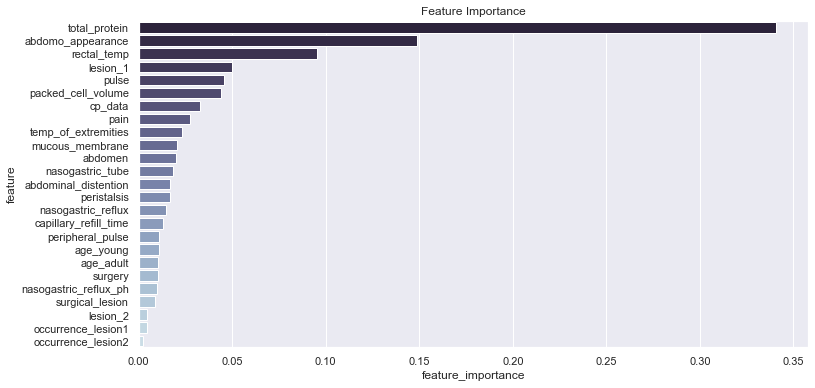

In [74]:
# train random forest classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# feature importance data frame
feat_imp = pd.DataFrame({'feature': X_train.columns,
                        'feature_importance': rf.feature_importances_})\
                        .sort_values('feature_importance', ascending=False)\
                        .reset_index(drop=True)


# plot feature importance
plt.subplots(figsize=(12,6))
sns.barplot(x='feature_importance', y='feature', data=feat_imp, orient='h', palette="ch:s=.25,rot=-.25_r")\
    .set_title('Feature Importance');

In [75]:
#cols = ['total_protein', 'abdomo_appearance', 'rectal_temp', 'lesion_1', 'pulse', 'packed_cell_volume', 'cp_data', 'pain']
#X_train = X_train[cols]
#X_test = X_test[cols]

# 7.0 Machine Learning

## 7.1 KNN

In [76]:
knn_model = KNeighborsClassifier(n_neighbors = 5)

knn_model.fit(X_train, y_train.values.ravel())

yhat_knn = knn_model.predict_proba(X_test)

## 7.2 Random Forest Classifier

In [77]:
rf_model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)

rf_model.fit(X_train, y_train.values.ravel())

yhat_rf = rf_model.predict_proba(X_test)

## 7.3 Extra Tree Classifier

In [78]:
et_model = ExtraTreesClassifier(n_estimators=100, n_jobs=-1, random_state=42)

et_model.fit(X_train, y_train.values.ravel())

yhat_et = et_model.predict_proba(X_test)

## 7.4 XGboost Classifier

In [79]:
xgb_model = xgb.XGBClassifier(n_estimators=100, n_jobs=-1, random_state=42, eval_metric='mlogloss')

xgb_model.fit(X_train, y_train.values.ravel())

yhat_xgb = xgb_model.predict_proba(X_test)

## 7.5 LGBM Classifier

In [80]:
lgbm_model = LGBMClassifier(n_jobs=-1, random_state=42)

lgbm_model.fit(X_train, y_train.values.ravel())

yhat_lgbm = lgbm_model.predict_proba(X_test)

## 7.6 Model Performance

<AxesSubplot:title={'center':'LGBM'}, xlabel='Percentage of sample', ylabel='Gain'>

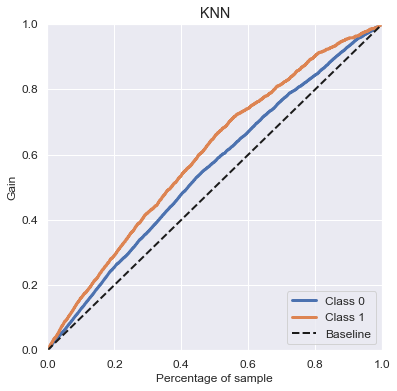

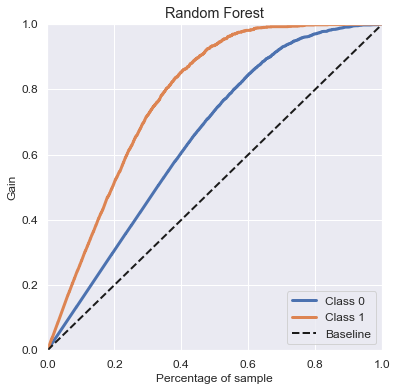

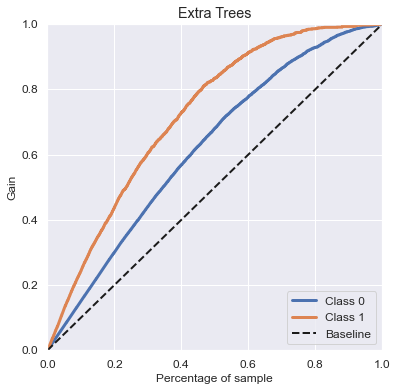

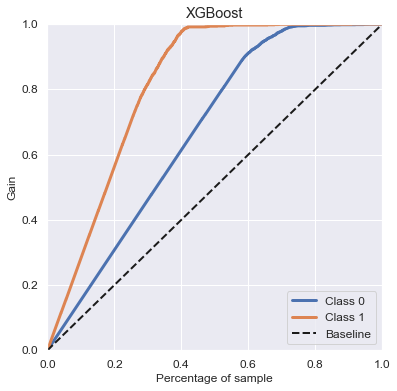

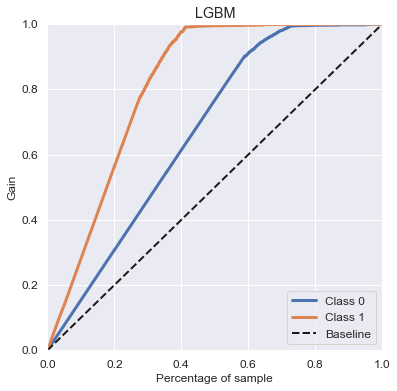

In [81]:
mtr.plot_cumulative_gain(y_test, yhat_knn, figsize=(6,6), title ='KNN');
mtr.plot_cumulative_gain(y_test, yhat_rf, figsize=(6,6), title = 'Random Forest' )
mtr.plot_cumulative_gain(y_test, yhat_et, figsize=(6,6), title = 'Extra Trees')
mtr.plot_cumulative_gain(y_test, yhat_xgb, figsize=(6,6), title ='XGBoost')
mtr.plot_cumulative_gain(y_test, yhat_lgbm, figsize=(6,6), title='LGBM' )

In [82]:
models = [knn_model, rf_model, et_model, xgb_model, lgbm_model]

In [83]:
knn_values_roc = roc_cross_validation(0, 5, verbose=False)
rf_values_roc = roc_cross_validation(1, 5, verbose=False)
et_values_roc = roc_cross_validation(2, 5, verbose=False)
xgb_values_roc = roc_cross_validation(3, 5, verbose=False)
lgbm_values_roc = roc_cross_validation(4, 5, verbose=False)

In [84]:
result = pd.DataFrame({'Model': 'KNN', 'ROC_AUC': np.round(mean(knn_values_roc), 4).astype(str) + ' +/- ' + np.round(std(knn_values_roc), 4).astype(str)}, index=[0])
result = result.append({'Model': 'RF', 'ROC_AUC': np.round(mean(rf_values_roc), 4).astype(str) + ' +/- ' + np.round(std(rf_values_roc), 4).astype(str)}, ignore_index=True)
result = result.append({'Model': 'ET', 'ROC_AUC': np.round(mean(et_values_roc), 4).astype(str) + ' +/- ' + np.round(std(et_values_roc), 4).astype(str)}, ignore_index=True)
result = result.append({'Model': 'XGB', 'ROC_AUC': np.round(mean(xgb_values_roc), 4).astype(str) + ' +/- ' + np.round(std(xgb_values_roc), 4).astype(str)}, ignore_index=True)
result = result.append({'Model': 'LGBM', 'ROC_AUC': np.round(mean(lgbm_values_roc), 4).astype(str) + ' +/- ' + np.round(std(lgbm_values_roc), 4).astype(str)}, ignore_index=True)
result

,Model,ROC_AUC
0,KNN,0.4982 +/- 0.0023
1,RF,0.9357 +/- 0.0073
2,ET,0.8606 +/- 0.0058
3,XGB,0.9846 +/- 0.0019
4,LGBM,0.9851 +/- 0.0015


## 7.7 Final Model

             Model  accuracy  precision    recall  roc_auc_score  f1_score
0  LGBM Classifier    0.9365   0.905941  0.913695       0.985238  0.909801


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

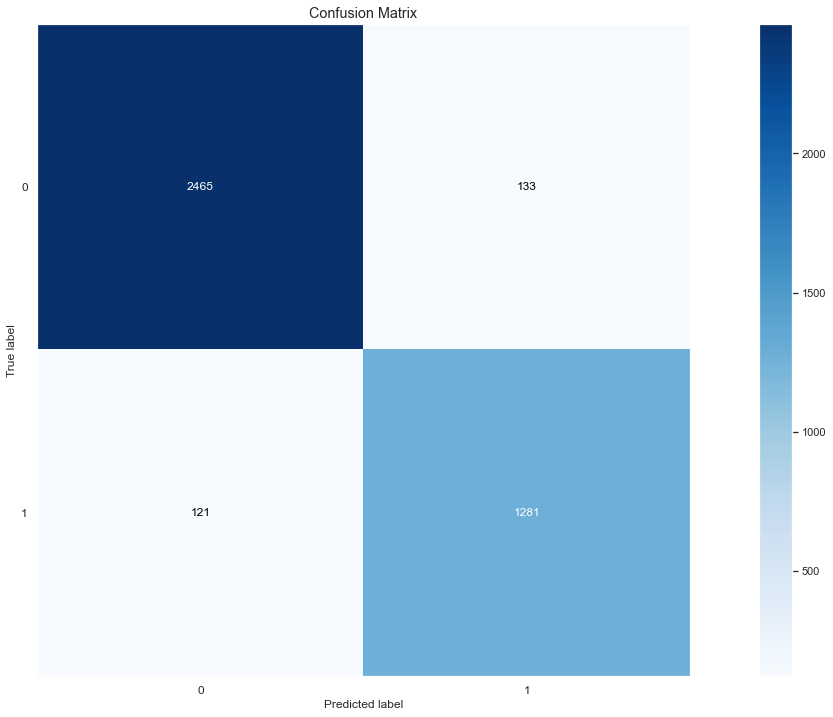

In [85]:
y_test_prediction= y_test.copy()

y_test_prediction['class0']= yhat_lgbm [:,0]
y_test_prediction['class1']= yhat_lgbm [:,1]

y_test_prediction['prediction'] = y_test_prediction['class0'].apply(lambda x: 0 if x > 0.5 else 1)

metrics = metrics_score('LGBM Classifier', y_test_prediction['outcome'], y_test_prediction['prediction'])
print(metrics)

mtr.plot_confusion_matrix(y_test_prediction['outcome'], y_test_prediction['prediction'])

# 8.0 Hyperparameter Fine Tuning

In [86]:
lgbm_model_hft_dart = LGBMClassifier(boosting_type = 'dart', n_jobs=-1, random_state=42)

lgbm_model_hft_dart.fit(X_train, y_train.values.ravel())

yhat_lgbm_hft_dart = lgbm_model_hft_dart.predict_proba(X_test)


y_test_prediction['dart_prediction'] = yhat_lgbm_hft_dart[:, 0]
y_test_prediction['dart_prediction'] = y_test_prediction['dart_prediction'].apply(lambda x: 0 if x > 0.5 else 1)


lgbm_model_hft_goss = LGBMClassifier(boosting_type = 'goss', n_jobs=-1, random_state=42)

lgbm_model_hft_goss.fit(X_train, y_train.values.ravel())

yhat_lgbm_hft_goss = lgbm_model_hft_goss.predict_proba(X_test)


y_test_prediction['goss_prediction'] = yhat_lgbm_hft_goss[:, 0]
y_test_prediction['goss_prediction'] = y_test_prediction['goss_prediction'].apply(lambda x: 0 if x > 0.5 else 1)


metrics = metrics.append(metrics_score('DART boosting', y_test_prediction['outcome'], y_test_prediction['dart_prediction']), ignore_index=True)
metrics = metrics.append(metrics_score('GOSS boosting', y_test_prediction['outcome'], y_test_prediction['goss_prediction']), ignore_index=True)

In [87]:
metrics

,Model,accuracy,precision,recall,roc_auc_score,f1_score
0,LGBM Classifier,0.9365,0.905941,0.913695,0.985238,0.909801
1,DART boosting,0.9340,0.938367,0.868759,0.985238,0.902222
2,GOSS boosting,0.9370,0.906648,0.914408,0.985238,0.910511


In [88]:
y_test_prediction.head()

,outcome,class0,class1,prediction,dart_prediction,goss_prediction
19156,1,0.089219,0.910781,1,1,1
12340,1,0.066334,0.933666,1,1,1
7718,0,0.549032,0.450968,0,0,0
19619,0,0.871254,0.128746,0,0,0
19983,0,0.996137,0.003863,0,0,0


# 9.0 Business Performance

In [89]:
df_test = y_test_prediction[['outcome', 'prediction']].copy()

In [90]:
df_test['TP'] = df_test['prediction'] * df_test['outcome']
tp = df_test['TP'].sum()

df_test['TN'] = df_test['prediction'] + df_test['outcome']
df_test['TN'] = df_test['TN'].apply(lambda x: 1 if x==0 else 0)
tn = df_test['TN'].sum()

df_test['FP'] = df_test['prediction'] - df_test['outcome']
df_test['FP'] = df_test['FP'].apply(lambda x: 1 if x==1 else 0)
fp = df_test['FP'].sum()

df_test['FN'] = df_test['outcome'] - df_test['prediction']
df_test['FN'] = df_test['FN'].apply(lambda x: 1 if x==1 else 0)
fn = df_test['FN'].sum()

## 9.1 Model Accuracy

In [91]:
print('The model has an accuracy of {}'.format((tp+tn)/4000))

The model has an accuracy of 0.9365


## 9.2 Main Insights

Almost half of young horses have died and 66.2% of adult horses survived

There is almost the same percentage of deaths for different levels of pain

without nasogastric reflux the percentage of deaths was higher

There is a higher percentage of deaths among horses with normal abdomen

The risk of death is higher when the total protein value is less than 10 gms/dL

## 9.3 Profit without the Model

In [92]:
print('The profit without the model for the next 400 horses is ${}'.format((((tn + fp) * 400) + ((tp + fn) * 300)) /10))

The profit without the model for the next 400 horses is $145980.0


## 9.4 Profit with the model

In [93]:
profit = ((tp * 200) + (tn*100) - (fn*200) - (fp*200))/10

In [94]:
print('With the model the profit will improve ${} for the next 400 horses'.format(profit))

With the model the profit will improve $45190.0 for the next 400 horses


# 10.0 Deploy

In [95]:
#Saving trained Model

pickle.dump(lgbm_model, open('trained_model/model.pkl', 'wb'))

pickle.dump(mms, open('preparation/mms_rectal_temp.pkl', 'wb'))
pickle.dump(mms, open('preparation/mms_pulse.pkl', 'wb'))
pickle.dump(mms, open('preparation/mms_packed_cell_volume.pkl', 'wb'))
pickle.dump(mms, open('preparation/mms_total_protein.pkl', 'wb'))


## 10.1 Principal Class

In [103]:
import pickle
import numpy as np
import pandas as pd

class Principal:
    def __init__(self):
        self.rectal_temp = pickle.load(open('preparation/mms_rectal_temp.pkl', 'rb'))
        self.pulse = pickle.load(open('preparation/mms_pulse.pkl', 'rb'))
        self.packed_cell_volume = pickle.load(open('preparation/mms_packed_cell_volume.pkl', 'rb'))
        self.total_protein = pickle.load(open('preparation/mms_total_protein.pkl', 'rb'))
        
    def data_cleaning (self, df):
        
        df['occurrence_lesion1'] = df['lesion_1'].apply(lambda x: 0 if x==0 else 1)
        df['occurrence_lesion2'] = df['lesion_2'].apply(lambda x: 0 if x==0 else 1)
        
        return df
    
    def data_filtering (self, df):
    
        df = df.drop(['hospital_number', 'lesion_3'], axis=1)
    
        return df
    
    def data_preparation (self, df):
    
        #surgery
        df['surgery'] = df['surgery'].apply(lambda x: 1 if x=='yes' else 0)

        #temp_of_extremities
        df['temp_of_extremities'] = df['temp_of_extremities'].apply(lambda x: 0 if x=='cold' else 1 if x=='cool' else 2 if x=='normal' else 3)

        #peripheral_pulse
        df['peripheral_pulse'] = df['peripheral_pulse'].apply(lambda x: 0 if x=='absent' else 1 if x=='reduced' else 2 if x=='normal' else 3)

        #capillary_refill_time
        df['capillary_refill_time'] = df['capillary_refill_time'].apply(lambda x: 0 if x=='less_3_sec' else 1 if x=='3' else 2)

        #pain
        df['pain'] = df['pain'].apply(lambda x: 0 if x=='mild_pain' else 1 if x=='depressed' else 2 if x=='alert' else 3 if x=='severe_pain' else 4)

        #peristalsis
        df['peristalsis'] = df['peristalsis'].apply(lambda x: 0 if x=='absent' else 1 if x=='hypomotile' else 2 if x=='normal' else 3)

        #abdominal_distention
        df['abdominal_distention'] = df['abdominal_distention'].apply(lambda x: 0 if x=='none' else 1 if x=='slight' else 2 if x=='moderate' else 3)

        #abdomen
        df['abdomen'] = df['abdomen'].apply(lambda x: 0 if x=='other' else 1 if x=='normal' else 2 if x=='firm' else 3 if x=='distend_small' else 4)

        #abdomo_appearance
        df['abdomo_appearance'] = df['abdomo_appearance'].apply(lambda x: 0 if x=='clear' else 1 if x=='cloudy' else 2)

        #surgical_lesion
        df['surgical_lesion'] = df['surgical_lesion'].apply(lambda x: 1 if x=='yes' else 0)

        #cp_data
        df['cp_data'] = df['cp_data'].apply(lambda x: 1 if x=='yes' else 0)
        
        #age
        df = pd.get_dummies(df, prefix='age', columns=['age'])
        
        #mucous_membrane
        fe_mm = df['mucous_membrane'].value_counts(normalize=True)
        df.loc[:, 'mucous_membrane'] = df['mucous_membrane'].map(fe_mm)

        #lesion_1
        fe_l1 = df['lesion_1'].value_counts(normalize=True)
        df.loc[:, 'lesion_1'] = df['lesion_1'].map(fe_l1)

        #lesion_2
        fe_l2 = df['lesion_2'].value_counts(normalize=True)
        df.loc[:, 'lesion_2'] = df['lesion_2'].map(fe_l2)
        
        #rectal_temp
        df['rectal_temp'] = self.rectal_temp.transform(df[['rectal_temp']].values)
        
        #pulse
        df['pulse'] = self.pulse.transform(df[['pulse']].values)
        
        #packed_cell_volume
        df['packed_cell_volume'] = self.packed_cell_volume.transform(df[['packed_cell_volume']].values)
        
        #total_protein
        df['total_protein'] = self.total_protein.transform(df[['total_protein']].values)
        
        return df
    
    def get_prediction (self, model, original_data, test_data):
        #model prediction
        pred = model.predict_proba(test_data)
        
        #join prediction into original data
        original_data['prediction'] = pred[:,1]
        
        return original_data.to_json(orient = 'records', date_format='iso')

## 10.2 API Handler

In [100]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from main.Principal import Principal
from lightgbm                import LGBMClassifier

# Loading model
model = pickle.load(open('trained_model/model.pkl', 'rb'))

# initialize API
app = Flask( __name__ )

@app.route( '/path/predict', methods=['POST'] )
def path_predict():
    test_json = request.get_json()
    
    if test_json: #there is data
        if isinstance( test_json, dict ): #unique example
            test_raw = pd.DataFrame( test_json, index=[0])
            
        else: # multiple example
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys() )
            
        #instantiate
        pipeline = Principal()
        
        # data cleaning
        df = pipeline.data_cleaning(test_raw)
        
        # data filtering
        df = pipeline.data_filtering(df)
        
        # data preparation
        df = pipeline.data_preparation(df)
        
        #prediction
        df_response = pipeline.get_prediction( model, test_raw, df)
        
        return df_response
    
    else:
        return Response( '{}', status=200, mimetype='application/json')
    
if __name__ == '__main__':
    app.run ( '0.0.0.0', debug=True)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Restarting with stat


SystemExit: 1

C:\Users\Igor Justino\.conda\envs\dsproduction\lib\site-packages\IPython\core\interactiveshell.py:3445: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## 10.3 API

In [95]:
#loading test dataset

df10 = df1.head(5).copy()

#drop 'outcome'
df10 = df10.drop('outcome', axis=1)

#convert into json
data = json.dumps(df10.to_dict(orient='records'))

In [96]:
# API Call

url = 'https://horse-colic-death-prediction.herokuapp.com/path/predict'

header = {'Content-type': 'application/json' }

r = requests.post( url = url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [97]:
df_result = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [98]:
df_result

,surgery,age,hospital_number,rectal_temp,pulse,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,abdomen,packed_cell_volume,total_protein,abdomo_appearance,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,occurrence_lesion1,occurrence_lesion2,prediction
0,no,young,5294539,38.2,52.0,warm,normal,normal_pink,less_3_sec,alert,hypermotile,none,1,1,0,normal,33.0,3.3,clear,no,0,0,0,no,0,0,0.003102
1,no,adult,530670,37.3,50.0,cool,normal,normal_pink,less_3_sec,alert,hypermotile,none,2,1,0,normal,42.0,6.0,cloudy,no,0,0,0,no,0,0,0.595040
2,no,adult,529960,38.6,56.0,cool,increased,pale_pink,less_3_sec,alert,hypermotile,none,1,1,0,normal,42.0,7.3,clear,no,0,0,0,no,0,0,0.595040
3,no,adult,530360,38.3,50.0,cool,normal,normal_pink,less_3_sec,alert,hypermotile,none,2,1,0,normal,42.0,7.5,clear,no,0,0,0,yes,0,0,0.595040
4,no,adult,530670,37.3,40.0,warm,normal,normal_pink,less_3_sec,alert,hypermotile,none,0,0,0,normal,39.0,6.0,cloudy,no,0,0,0,no,0,0,0.543301
